### Juice analysis for multiple campaigns is meant to be here. Producing of the files should be done entirely in the scripts for the single campaigns
#### Analysis for every discharge
- max. and average intensities of spectral lines (from AEF and AEI spectrometers)
- line ratios based on these intensities
- radiation fronts from the AEI view (only IP320_3 gives reliable data)
- strikelines from AEF views
#### Analysis for special discharges
- Line ratio analysis fitted to strikelines (multiple for standard for example)
- stark broadening for 


In [91]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import importlib
import os
import logging
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("divertor_spectroscopy")
logger.setLevel(logging.DEBUG)

from w7xdia import extractor

from divertor_spectroscopy import qss_juice
from divertor_spectroscopy import qsq_juice
from divertor_spectroscopy import utilities as utils
from divertor_spectroscopy import atomic_data
from divertor_spectroscopy import analysis


fontsize = 14
plt.rcParams.update({'font.size': fontsize})
ground_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/"
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + colors[1:]

In [2]:
campaigns = ["OP2.1","OP2.2"]
juice_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/juice/"

### Load the Juices from different campaigns and combine them

In [3]:
juice_paths = ["OP2.1/adb_juice_all_op21_step_0.2_v0.1.csv","OP2.2/adb_juice_all_op22_step_0.2_v0.1.csv"]
juices = []
for path in juice_paths:
    juices.append(pd.read_csv(juice_path+path, index_col=0))
juice = pd.concat(juices)

c:\Users\frhe\AppData\Local\anaconda3\envs\qss\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (67,76,417,423,425,426,449,451,453,455,457,459,461,463,465,467) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\frhe\AppData\Local\anaconda3\envs\qss\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (45,47,49,51,53,55,57,59,61,63,65,111) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
for column in juice.columns:
    print(column)

shot
t1
t_shot_start
t_shot_stop
t_in_shot
time_step
campaign
postboronization
w7xdia_version
archivedb_version
temp_degC_AEA21u
dtemp_degC_AEA21u_dt
sigma_temp_degC_AEA21u
min_temp_degC_AEA21u
max_temp_degC_AEA21u
temp_degC_AEA21o
dtemp_degC_AEA21o_dt
sigma_temp_degC_AEA21o
min_temp_degC_AEA21o
max_temp_degC_AEA21o
temp_degC_AEF30_ZnSe
dtemp_degC_AEF30_ZnSe_dt
sigma_temp_degC_AEF30_ZnSe
min_temp_degC_AEF30_ZnSe
max_temp_degC_AEF30_ZnSe
temp_degC_AEF30_sapphire
dtemp_degC_AEF30_sapphire_dt
sigma_temp_degC_AEF30_sapphire
min_temp_degC_AEF30_sapphire
max_temp_degC_AEF30_sapphire
temp_degC_AEF30_frontplate
dtemp_degC_AEF30_frontplate_dt
sigma_temp_degC_AEF30_frontplate
min_temp_degC_AEF30_frontplate
max_temp_degC_AEF30_frontplate
ecrh_total_MW
t_ecrh_start
t_ecrh_stop
decrh_total_dt_MW_s
sigma_ecrh_total_MW
min_ecrh_total_MW
max_ecrh_total_MW
ecrh_total_energy_per_interval_MJ
ecrh_total_energy_running_MJ
ecrh_total_energy_MJ
ecrh_version
nbi_total_MW
t_nbi_start
t_nbi_stop
shot_with_nbi
d

In [5]:
if False:
    for key in juice.columns:
        print(key)

### You can pretty easily make your own juice file by using the extractor. This is done in other scripts - here we just read juice files for the campaigns and concatenate them
- idea is to concatenate everything we have from OP2.1 and OP2.2. I want to read only one file per campaign

In [6]:
time_inshot = {'label':"Time from t1 [s]", 'data':juice['t_in_shot'], 'min':0.0, 'max':200}
#pRad = { 'label':"P$_{rad}$ [MW]", 'data':(juice['prad_hbc_MW']+juice['prad_vbc_MW'])/2, 'min':0, 'max':7}
pRad = { 'label':"P$_{rad}$ [MW]", 'data':juice['prad_hbc_MW'], 'min':0, 'max':7} # no vbc data for OP2.1 so I have to use hbc or I need to change this in the single juices
pRad_hbc = { 'label':"P$_{rad}$ [MW]", 'data':juice['prad_hbc_MW'], 'min':0, 'max':7}
pRad_vbc = { 'label':"P$_{rad}$ [MW]", 'data':juice['prad_vbc_MW'], 'min':0, 'max':7}
power = {'label':"P$_{ECRH}$ [MW]", 'data':np.nan_to_num(juice['ecrh_total_MW']), 'min':0, 'max': 7}
power_nbi = {'label':"P$_{NBI}$ [MW]", 'data':np.nan_to_num(juice["nbi_total_MW"])*0.8, 'min':0, 'max': 7}
total_power = {'label':"P$_{total}$ [MW]", 'data':np.nan_to_num(power["data"])+np.nan_to_num(power_nbi["data"]), 'min':0, 'max': 10}
power_target = {'label':"P$_{target}$ [MW]", 'data':total_power["data"]-pRad["data"], 'min':0, 'max': 7}
pFraction = { 'label':"$P_{rad}/P_{heat}$", 'data':pRad["data"]/total_power["data"], 'min':0, 'max':1.2}
pFraction_hbc = { 'label':"$P_{rad}/P_{heat}$", 'data':pRad_hbc["data"]/total_power["data"], 'min':0, 'max':1.2}
pFraction_vbc = { 'label':"$P_{rad}/P_{heat}$", 'data':pRad_vbc["data"]/total_power["data"], 'min':0, 'max':1.2}
control_coil_operation = {"label":"control coils operation","data":juice["shot_with_control_coils"],"min":0,"max":1}
control_coil_current = {"label":"Control Coil Current [kA]","data":juice["coil_control_1_kA"],"min":-2.5,"max":+2.5}
lineDensity = {'label':"Line integrated n$_e$ [$10^{19}$ m$^{-2}$]", 'data':juice['neL_1e19_m2'], 'min':0, 'max': 17}
Ip = {'label':"Ip", 'data':juice['ip_kA'], 'min':0, 'max': 8}
dWdia = {"label":"dWdia/dt","data":juice["dwdia_dt_MJ_s"],"min":-1,"max":1}
Wdia = {"label":"Wdia","data":juice["wdia_MJ"],"min":0,"max":1}


In [7]:
if False:
    boronizations = []
    plasma_exposure_times_of_boronizations = []
    for boronization in boronizations:
        for i,shot in enumerate(juice["shot"]):
            if int(boronization) < int(shot[3:11]):
                print(shot[3:11])
                plasma_exposure_times_of_boronizations.append(np.array(plasma_exposure_time["data"])[i])
                # leave loop
                break
    print(plasma_exposure_times_of_boronizations)

In [8]:
if False:
    from divertor_spectroscopy import qsq_juice
    pid = "20241212.080"
    qsq_juice.get_qsq_voltages_types_pressures_and_gas_amount(shotname=pid,debug=True)

In [9]:
flt = (juice["shot"]=="W7X20241212.080")
juice[flt]

shot                   t1  t_shot_start  \
1734015821662920001  W7X20241212.080  1734015822660000000       0.00292   
1734015821862920001  W7X20241212.080  1734015822660000000       0.00292   
1734015822062920001  W7X20241212.080  1734015822660000000       0.00292   
1734015822262920001  W7X20241212.080  1734015822660000000       0.00292   
1734015822462920001  W7X20241212.080  1734015822660000000       0.00292   
1734015822662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015822862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015823062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015823262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015823462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015823662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015823862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015824062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015824262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015824462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015824662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015824862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015825062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015825262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015825462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015825662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015825862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015826062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015826262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015826462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015826662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015826862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015827062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015827262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015827462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015827662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015827862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015828062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015828262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015828462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015828662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015828862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015829062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015829262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015829462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015829662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015829862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015830062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015830262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015830462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015830662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015830862920000  W7X20241212.080  1734015822660000000       0.00292   
1734015831062920000  W7X20241212.080  1734015822660000000       0.00292   
1734015831262920000  W7X20241212.080  1734015822660000000       0.00292   
1734015831462920000  W7X20241212.080  1734015822660000000       0.00292   
1734015831662920000  W7X20241212.080  1734015822660000000       0.00292   
1734015831862920000  W7X20241212.080  1734015822660000000       0.00292   

                     t_shot_stop  t_in_shot  time_step c

In [10]:
if True:
    #juice = juice_shot
    importlib.reload(qsq_juice)
    gases = ["N2","Ne"]
    for gas in gases:
        juice["GasInlet_qsq_"+gas+"_gas_amount_total"] = juice.apply(qsq_juice.sum_up_gas_amounts,axis=1,args=(gas,))
        juice["GasInlet_qsq_"+gas+"_gas_amount_integrated"] = juice.groupby('shot')["GasInlet_qsq_"+gas+"_gas_amount_total"].cumsum()
        globals()["GasInlet_qsq_"+gas+"_gas_amount_total"] = {"label":"GasInlet_qsq_"+gas+"_gas_amount_total","data":juice["GasInlet_qsq_"+gas+"_gas_amount_total"],
                                                            "min":0,
                                                            "max":np.nanmax(juice["GasInlet_qsq_"+gas+"_gas_amount_total"])}
        globals()["GasInlet_qsq_"+gas+"_gas_amount_integrated"] = {"label":"GasInlet_qsq_"+gas+"_gas_amount_integrated","data":juice["GasInlet_qsq_"+gas+"_gas_amount_integrated"]/1e15,
                                                            "min":0,
                                                            "max":np.nanmax(juice["GasInlet_qsq_"+gas+"_gas_amount_integrated"])/1e15}

In [118]:
if True:
    fit_parameters = []
    for element in list(juice.columns):
        if "qss_max_intensities_" in element:
            fit_parameters.append(element.split("qss_max_intensities_")[1])
            print(element)
    print(fit_parameters)
    for name in fit_parameters:
        globals()["qss_max_intensities_{}".format(name.replace(".","_"))] = {"label":"QSS max {}".format(name),"data":juice["qss_max_intensities_{}".format(name)]/1e15,
                                                        "min":np.nanmin(juice["qss_max_intensities_{}".format(name)])/1e15,
                                                        "max":np.nanmax(juice["qss_max_intensities_{}".format(name)])/1e15}
        globals()["qss_max_intensities_{}".format(name.replace(".","_"))] = {"label":"QSS max {}".format(name),"data":juice["qss_max_intensities_{}".format(name)]/1e15,
                                                        "min":np.nanmin(juice["qss_max_intensities_{}".format(name)])/1e15,
                                                        "max":np.nanmax(juice["qss_max_intensities_{}".format(name)])/1e15}
    qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"] = qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"]*1.2
    qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"] = qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"]*1.2
    line_ratio_horizontal_AEF51_neII1 = {"label":"Neon line ratio 357.1 / 371.3","data":qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_357_111["data"]/qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_315["data"], 'min':0, 'max': 1}
    line_ratio_horizontal_AEF51_neII2 = {"label":"Neon line ratio 371.7 / 371.3","data":qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"]/(qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_315["data"]*1.07), 'min':0, 'max': 1}
    line_ratio_vertical_AEF51_neII1 = {"label":"Neon line ratio 357.1 / 371.3","data":qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_357_111["data"]/qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_315["data"], 'min':0, 'max': 1}
    line_ratio_vertical_AEF51_neII2 = {"label":"Neon line ratio 371.7 / 371.3","data":qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"]/(qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_315["data"]*1.07), 'min':0, 'max': 1}
    if False:
        load_from_cache = False # Todo: load the cached data from the campaigns!
        if load_from_cache:
            pass
    # make ne, Te, nNe from the line ratios - also concentration in a second step
        ne_array, Te_array, frac, pecs, line_intensities = atomic_data.get_line_intensities(element="ne",ne_range=[5e18,50e19],Te_range=[2,5],ne_scale="log",debug=False)
        importlib.reload(atomic_data)
        electron_density_horizontal_AEF51_neII = {"label": "Local electron density NeII [1e18m$^{-3}$]","data": pd.Series(dtype='float64'),"min": 0,"max": 50}
        electron_temperature_horizontal_AEF51_neII = {"label": "Local electron temperature NeII [eV]","data": pd.Series(dtype='float64'),"min": 2,"max": 5}
        impurity_density_horizontal_AEF51_neII = {"label": "Local impurity density NeII [1e18m$^{-3}$]","data": pd.Series(dtype='float64'),"min": 0,"max": 50}
        electron_density_vertical_AEF51_neII = {"label": "Local electron density NeII [1e18m$^{-3}$]","data": pd.Series(dtype='float64'),"min": 0,"max": 50}
        electron_temperature_vertical_AEF51_neII = {"label": "Local electron temperature NeII [eV]","data": pd.Series(dtype='float64'),"min": 2,"max": 5}
        impurity_density_vertical_AEF51_neII = {"label": "Local impurity density Ne [1e18m$^{-3}$]","data": pd.Series(dtype='float64'),"min": 0,"max": 50}
    # todo: this one takes an hour, so you should cache it, when you apply this the next time
        # Processing horizontal data
        for i, (index, line_intensity1, line_intensity2, line_intensity3) in enumerate(
                zip(qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_357_111["data"].index,
                    qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_357_111["data"]*1e15,
                    qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_315["data"]*1e15,
                    qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"]*1e15)):
            if np.isnan(line_intensity1):
                electron_density_horizontal_AEF51_neII["data"].at[index] = np.nan
                electron_temperature_horizontal_AEF51_neII["data"].at[index] = np.nan
                impurity_density_horizontal_AEF51_neII["data"].at[index] = np.nan
            else:
                try:
                    ne, Te, nNi = atomic_data.get_ne_Te_nNe_from_tapete(
                        ne_array=ne_array, Te_array=Te_array, line_intensity_array=line_intensities,
                        line_intensity1=line_intensity1, line_intensity2=line_intensity2, line_intensity3=line_intensity3,
                        ne_scale="log", Te_scale="linear")
                except:
                    ne, Te, nNi = np.nan, np.nan, np.nan
                electron_density_horizontal_AEF51_neII["data"].at[index] = ne
                electron_temperature_horizontal_AEF51_neII["data"].at[index] = Te
                impurity_density_horizontal_AEF51_neII["data"].at[index] = nNi
        # Processing vertical data
        for i, (index, line_intensity1, line_intensity2, line_intensity3) in enumerate(
                zip(qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_357_111["data"].index,
                    qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_357_111["data"]*1e15,
                    qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_315["data"]*1e15,
                    qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"]*1e15)):
            if np.isnan(line_intensity1):
                electron_density_vertical_AEF51_neII["data"].at[index] = np.nan
                electron_temperature_vertical_AEF51_neII["data"].at[index] = np.nan
                impurity_density_vertical_AEF51_neII["data"].at[index] = np.nan
            else:
                try:
                    ne, Te, nNi = atomic_data.get_ne_Te_nNe_from_tapete(
                        ne_array=ne_array, Te_array=Te_array, line_intensity_array=line_intensities,
                        line_intensity1=line_intensity1, line_intensity2=line_intensity2, line_intensity3=line_intensity3,
                        ne_scale="log", Te_scale="linear")
                except:
                    ne, Te, nNi = np.nan, np.nan, np.nan
                electron_density_vertical_AEF51_neII["data"].at[index] = ne
                electron_temperature_vertical_AEF51_neII["data"].at[index] = Te
                impurity_density_vertical_AEF51_neII["data"].at[index] = nNi
        impurity_concentration_horizontal_AEF51_neII = {"label": "Local impurity concentration Ne [%]","data": 100*impurity_density_horizontal_AEF51_neII["data"] / electron_density_horizontal_AEF51_neII["data"],"min": 0,"max": 1000}
        impurity_concentration_vertical_AEF51_neII = {"label": "Local impurity concentration Ne [%]","data": 100*impurity_density_vertical_AEF51_neII["data"] / electron_density_vertical_AEF51_neII["data"],"min": 0,"max": 1000}
    else:
        columns_to_extract = [
            ("electron_density_vertical_AEF51_neII", "Local electron density NeII [1e18m$^{-3}$]"),
            ("electron_temperature_vertical_AEF51_neII", "Local electron temperature NeII [eV]"),
            ("impurity_density_vertical_AEF51_neII", "Local impurity density Ne [1e18m$^{-3}$]"),
            ("impurity_concentration_vertical_AEF51_neII", "Local impurity concentration Ne [%]"),
            ("electron_density_horizontal_AEF51_neII", "Local electron density NeII [1e18m$^{-3}$]"),
            ("electron_temperature_horizontal_AEF51_neII", "Local electron temperature NeII [eV]"),
            ("impurity_density_horizontal_AEF51_neII", "Local impurity density NeII [1e18m$^{-3}$]"),
            ("impurity_concentration_horizontal_AEF51_neII", "Local impurity concentration Ne [%]"),
        ]

        # Dictionaries erzeugen
        dictionaries = {}

        for column_name, label in columns_to_extract:
            # Extrahiere die Spaltenwerte als Serie
            data_series = juice[column_name]
            
            # Erstelle das Dictionary
            dictionaries[column_name] = {
                "label": label,
                "data": data_series,
                "min": data_series.min(),
                "max": data_series.max()
            }

        # Zugriff auf die erzeugten Dictionaries
        electron_density_vertical_AEF51_neII = dictionaries["electron_density_vertical_AEF51_neII"]
        electron_temperature_vertical_AEF51_neII = dictionaries["electron_temperature_vertical_AEF51_neII"]
        impurity_density_vertical_AEF51_neII = dictionaries["impurity_density_vertical_AEF51_neII"]
        impurity_concentration_vertical_AEF51_neII = dictionaries["impurity_concentration_vertical_AEF51_neII"]

        electron_density_horizontal_AEF51_neII = dictionaries["electron_density_horizontal_AEF51_neII"]
        electron_temperature_horizontal_AEF51_neII = dictionaries["electron_temperature_horizontal_AEF51_neII"]
        impurity_density_horizontal_AEF51_neII = dictionaries["impurity_density_horizontal_AEF51_neII"]
        impurity_concentration_horizontal_AEF51_neII = dictionaries["impurity_concentration_horizontal_AEF51_neII"]

    line_ratio_vertical_AEF51_nII1_v_nitrogen4 = {"label":"Nitrogen line ratio 404.1 / 399.5","data":qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_404_098["data"]/qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
    line_ratio_horizontal_AEF51_nII1_v_nitrogen4 = {"label":"Nitrogen line ratio 404.1 / 399.5","data":qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_404_098["data"]/qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
    line_ratio_vertical_AEF51_nII2_v_nitrogen4 = {"label":"Nitrogen line ratio 404.1 / 402.6","data":qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_404_098["data"]/qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_402_683["data"], 'min':0, 'max': 1}
    line_ratio_horizontal_AEF51_nII2_v_nitrogen4 = {"label":"Nitrogen line ratio 404.1 / 402.6","data":qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_404_098["data"]/qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_402_683["data"], 'min':0, 'max': 1}
        
if True:
        #line_ratio_horizontal_AEF51_neII1 = {"label":"Neon line ratio 357.1 / 371.3","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_357_111["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315["data"], 'min':0, 'max': 1}
        #line_ratio_horizontal_AEF51_neII2 = {"label":"Neon line ratio 371.3 / 371.7","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"], 'min':0, 'max': 1}
        #line_ratio_vertical_AEF51_neII1 = {"label":"Neon line ratio 357.1 / 371.3","data":qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_357_111["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_315["data"], 'min':0, 'max': 1}
        #line_ratio_vertical_AEF51_neII2 = {"label":"Neon line ratio 371.3 / 371.7","data":qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_315["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_755["data"], 'min':0, 'max': 1}
        #line_ratio_vertical_AEF51_nII = {"label":"Nitrogen line ratio 404.1 / 399.5","data":qss_max_intensities_AEF51_vertical_v1_Intensity_NII_404_098["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        #line_ratio_horizontal_AEF51_nII = {"label":"Nitrogen line ratio 404.1 / 399.5","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_404_098["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        
         line_ratio_vertical_AEF51_balmer_epsilon_delta_op21 = {"label":"Balmer line ratio epsilon / delta","data":qss_max_intensities_AEF51_vertical_v1_Intensity_Balmer_H_epsilon["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_Balmer_H_delta["data"], 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_balmer_epsilon_delta_op21 = {"label":"Balmer line ratio epsilon / delta","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_Balmer_H_epsilon["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_Balmer_H_delta["data"], 'min':0, 'max': 1}
         line_ratio_vertical_AEF51_balmer_epsilon_delta_op22 = {"label":"Balmer line ratio epsilon / delta","data":qss_max_intensities_AEF51_vertical_v1_Intensity_HI_397_007["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_HI_410_173["data"], 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_balmer_epsilon_delta_op22 = {"label":"Balmer line ratio epsilon / delta","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_397_007["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_410_173["data"], 'min':0, 'max': 1}
        
        # line_ratio_vertical_AEF51_h_to_he = {"label":"Balmer Delta to HeI 396 vertical","data":qss_max_intensities_AEF51_vertical_v1_Intensity_Balmer_H_delta["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_HeI_396_473["data"], 'min':0, 'max': 1000}
        # line_ratio_horizontal_AEF51_h_to_he = {"label":"Balmer Delta to HeI 396 horizontal","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_Balmer_H_delta["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_396_473["data"], 'min':0, 'max': 1000}
        # line_ratio_horizontal_AEF51_cIII = {"label":"CIII line ratio 406 / 360","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_406_926["data"] / qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_360_934["data"], 'min':0, 'max': 1}
        # line_ratio_vertical_AEF51_cIII = {"label":"CIII line ratio 406 / 360","data":qss_max_intensities_AEF51_vertical_v1_Intensity_CIII_406_926["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_CIII_360_934["data"], 'min':0, 'max': 1}
        # line_ratio_vertical_AEF51_oII_to_cII = {"label": "OII/CII 396 / 407","data":qss_max_intensities_AEF51_vertical_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_CII_407_528["data"], 'min':0, 'max': 1}
        # line_ratio_horizontal_AEF51_oII_to_cII = {"label":"OII/CII 396 / 407","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_407_528["data"], 'min':0, 'max': 1}
        # line_ratio_vertical_AEF51_oII_to_nii = {"label": "OII 396 / NII 399","data":qss_max_intensities_AEF51_vertical_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        # line_ratio_horizontal_AEF51_oII_to_nii = {"label":"OII 396 / NII 399","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
         line_ratio_vertical_AEF51_oII_to_nii_log = {"label": "log OII 396 / NII 399","data":np.log10(qss_max_intensities_AEF51_vertical_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]), 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_oII_to_nii_log = {"label":"log OII 396 / NII 399","data":np.log10(qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]), 'min':0, 'max': 1}
         line_ratio_vertical_AEF51_heI_to_nii = {"label": "HeI 396 / NII 399","data":qss_max_intensities_AEF51_vertical_v1_Intensity_HeI_396_473["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_heI_to_nii = {"label":"HeI 396 / NII 399","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_396_473["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
         line_ratio_vertical_AEF51_heI_to_nii_log = {"label": "log HeI 396 / NII 399","data":np.log10(qss_max_intensities_AEF51_vertical_v1_Intensity_HeI_396_473["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]), 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_heI_to_nii_log = {"label":"log HeI 396 / NII 399","data":np.log10(qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_396_473["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]), 'min':0, 'max': 1}
         line_ratio_vertical_AEF51_oII_to_neii_log = {"label": "log OII 396 / NII 399","data":np.log10(qss_max_intensities_AEF51_vertical_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"]), 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_oII_to_neii_log = {"label":"log OII 396 / NII 399","data":np.log10(qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"]), 'min':0, 'max': 1}
         line_ratio_vertical_AEF51_oII_to_neii = {"label": "log OII 396 / NII 399","data":(qss_max_intensities_AEF51_vertical_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"]), 'min':0, 'max': 1}
         line_ratio_horizontal_AEF51_oII_to_neii = {"label":"log OII 396 / NII 399","data":(qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697["data"]/qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"]), 'min':0, 'max': 1}
         
        # line_ratio_vertical_AEF51_cII_to_nii = {"label": "CII 407 / NII 399","data":qss_max_intensities_AEF51_vertical_v1_Intensity_CII_407_528["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        # line_ratio_horizontal_AEF51_cII_to_nii = {"label":"CII 407 / NII 399","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_407_528["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"], 'min':0, 'max': 1}
        # line_ratio_vertical_AEF51_cII_to_nii_log = {"label": "log CII 407 / NII 399","data":np.log10(qss_max_intensities_AEF51_vertical_v1_Intensity_CII_407_528["data"]/qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]), 'min':0, 'max': 1}
        # line_ratio_horizontal_AEF51_cII_to_nii_log = {"label":"log CII 407 / NII 399","data":np.log10(qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_407_528["data"]/qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]), 'min':0, 'max': 1}        
        

qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_396.473
qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_402.621
qss_max_intensities_AEF51_horizontal_v1_Intensity_BII_412.193
qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_401.421
qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_407.528
qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_406.926
qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_395.585
qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399.500
qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_404.098
qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_413.794
qss_max_intensities_AEF51_horizontal_v1_Intensity_NIII_400.172
qss_max_intensities_AEF51_horizontal_v1_Intensity_NIII_409.937
qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396.697
qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_407.479
qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_396.836
qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_397.448
qss

### Average intensities:

In [12]:
if True:
    fit_parameters = []
    for element in list(juice.columns):
        if "qss_average_intensities_" in element:
            fit_parameters.append(element.split("qss_average_intensities_")[1])
            print(element)
    print(fit_parameters)
    for name in fit_parameters:
        globals()["qss_average_intensities_{}".format(name.replace(".","_"))] = {"label":"QSS average {}".format(name),"data":juice["qss_average_intensities_{}".format(name)]/1e15,
                                                        "min":np.nanmin(juice["qss_average_intensities_{}".format(name)])/1e15,
                                                        "max":np.nanmax(juice["qss_average_intensities_{}".format(name)])/1e15}
    line_ratio_average_oxygen_to_carbon = {"label":"OII/CII line ratio 396/407","data":qss_average_intensities_AEF51_v1_Intensity_OII_396_697["data"]/qss_average_intensities_AEF51_v1_Intensity_CII_407_528["data"], 'min':0, 'max': 1}
        


qss_average_intensities_AEF51_v1_Intensity_HeI_370.501
qss_average_intensities_AEF51_v1_Intensity_CIII_360.934
qss_average_intensities_AEF51_v1_Intensity_OII_373.597
qss_average_intensities_AEF51_v1_Intensity_OIII_370.598
qss_average_intensities_AEF51_v1_Intensity_OIV_373.352
qss_average_intensities_AEF51_v1_Intensity_NeII_357.111
qss_average_intensities_AEF51_v1_Intensity_NeII_371.315
qss_average_intensities_AEF51_v1_Intensity_NeII_371.046
qss_average_intensities_AEF51_v1_Intensity_ArII_354.584
qss_average_intensities_AEF51_v1_Intensity_ArII_354.854
qss_average_intensities_AEF51_v1_Intensity_ArII_355.954
qss_average_intensities_AEF51_v1_Intensity_ArII_356.103
qss_average_intensities_AEF51_v1_Intensity_ArII_357.665
qss_average_intensities_AEF51_v1_Intensity_ArII_358.235
qss_average_intensities_AEF51_v1_Intensity_ArII_358.848
qss_average_intensities_AEF51_v1_Intensity_ArII_371.821
qss_average_intensities_AEF51_v1_Intensity_ArII_372.934
qss_average_intensities_AEF51_v1_Intensity_ArIII_36

### Stark densities:
- Todo: change name "strikeline" to actual targets or no strikeline and add the instrument function, this is all still very wrong
- For now I can quick and dirty just use this as the only thing saved is the density measured in AEI30 at the horizontal target

In [13]:
if True:
    fit_parameters = []
    for element in list(juice.columns):
        if "H_gamma" in element or "H_delta" in element:
            fit_parameters.append(element)
            print(element)
    print(fit_parameters)
    for name in fit_parameters:
        if "Stark" in name:
            globals()["{}".format(name.replace(".","_"))] = {"label":name,"data":juice["{}".format(name)]/1e19,
                                                        "min":np.nanmin(juice["{}".format(name)])/1e19,
                                                        "max":np.nanmax(juice["{}".format(name)])/1e19}
        else:
            globals()["{}".format(name.replace(".","_"))] = {"label":name,"data":juice["{}".format(name)],
                                                        "min":np.nanmin(juice["{}".format(name)]),
                                                        "max":np.nanmax(juice["{}".format(name)])}

qss_max_intensities_AEF51_horizontal_v1_Intensity_Balmer_H_delta
qss_max_intensities_AEF51_vertical_v1_Intensity_Balmer_H_delta
qss_brightest_channel_strikeline_Intensity_H_gamma
qss_brightest_channel_strikeline_Stark_density_H_gamma
qss_brightest_channel_strikeline_Doppler_shift_H_gamma
qss_brightest_channel_strikeline_Intensity_H_delta
qss_brightest_channel_strikeline_Stark_density_H_delta
qss_brightest_channel_strikeline_Doppler_shift_H_delta
['qss_max_intensities_AEF51_horizontal_v1_Intensity_Balmer_H_delta', 'qss_max_intensities_AEF51_vertical_v1_Intensity_Balmer_H_delta', 'qss_brightest_channel_strikeline_Intensity_H_gamma', 'qss_brightest_channel_strikeline_Stark_density_H_gamma', 'qss_brightest_channel_strikeline_Doppler_shift_H_gamma', 'qss_brightest_channel_strikeline_Intensity_H_delta', 'qss_brightest_channel_strikeline_Stark_density_H_delta', 'qss_brightest_channel_strikeline_Doppler_shift_H_delta']


### Active spectroscopy

In [14]:
if True:
    fit_parameters = []
    for element in list(juice.columns):
        if "active" in element:
            fit_parameters.append(element)
            print(element)
    print(fit_parameters)
    for name in fit_parameters:
            globals()["{}".format(name.replace(".","_"))] = {"label":name,"data":juice["{}".format(name)]/1e19,
                                                        "min":np.nanmin(juice["{}".format(name)])/1e19,
                                                        "max":np.nanmax(juice["{}".format(name)])/1e19}

qss_active_intensities_Intensity_HeI_667.815
qss_active_intensities_Intensity_HeI_706.519
qss_active_intensities_Intensity_HeI_728.135
qss_active_intensities_Electron_temperature
qss_active_intensities_Electron_density
['qss_active_intensities_Intensity_HeI_667.815', 'qss_active_intensities_Intensity_HeI_706.519', 'qss_active_intensities_Intensity_HeI_728.135', 'qss_active_intensities_Electron_temperature', 'qss_active_intensities_Electron_density']


In [15]:
if False:
    flt = (juice["shot"]=="W7X20241212.080")
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(juice[flt])

### LBO and Tespel stuff from the two campaigns:

In [16]:
path = juice_path+"OP2.2/" + "LBO_TESPEL.npy"  # Path for saving/loading the list of discharges
LBO_TESPEL_op22 = np.load(path, allow_pickle=True).tolist()

LBO_TESPEL_op21 = [
            'W7X20221129.031', 'W7X20221129.032', 'W7X20221129.034',
            'W7X20221207.011', 'W7X20221207.036',
            'W7X20221213.012', 'W7X20221213.019', 'W7X20221213.020', 'W7X20221213.030',
            'W7X20221213.031', 'W7X20221213.040', 'W7X20221213.041', 'W7X20221213.043',
            'W7X20221213.044', 'W7X20221213.047', 'W7X20221213.048', 'W7X20221213.049',
            'W7X20221213.050', 'W7X20221213.052',
            'W7X20221214.039', 'W7X20221214.040',
            'W7X20230118.007',
            'W7X20230314.008', 'W7X20230314.009', 'W7X20230314.010', 'W7X20230314.011',
            'W7X20230314.015', 'W7X20230314.017', 'W7X20230314.020', 'W7X20230314.022',
            'W7X20230314.024', 'W7X20230314.025', 'W7X20230314.026', 'W7X20230314.027',
            'W7X20230314.028', 'W7X20230314.030', 'W7X20230314.032', 'W7X20230314.041',
            'W7X20230314.047', 'W7X20230314.049', 'W7X20230314.052', 'W7X20230314.053',
            'W7X20230314.061', 'W7X20230314.062', 'W7X20230314.064',
            'W7X20230315.018', 'W7X20230315.022', 'W7X20230315.024', 'W7X20230315.027',
            'W7X20230315.030', 'W7X20230315.031', 'W7X20230315.036', 'W7X20230315.037', 
            'W7X20230315.038', 'W7X20230315.039', 'W7X20230315.041', 
            'W7X20230316.005',
            'W7X20230323.004', 'W7X20230323.010', 'W7X20230323.011', 'W7X20230323.012',
            'W7X20230323.040', 'W7X20230323.041', 'W7X20230323.043', 'W7X20230323.044', 
            'W7X20230323.048', 'W7X20230323.051', 'W7X20230323.053', 'W7X20230323.057',
            'W7X20230323.058', 'W7X20230323.059', 'W7X20230323.061', 'W7X20230323.062',
            'W7X20230323.063',
            ]
LBO_TESPEL = LBO_TESPEL_op22 + LBO_TESPEL_op21
isLBO_TESPEL = np.array([i in LBO_TESPEL for i in list(juice["shot"])])
CORRUPTED_PRAD = ["20230209.001","20230209.002","20230209.004","20230209.004","20230209.005","20230209.006","20230209.007","20230209.008","20230209.009","20230209.010",
                  "20230209.011","20230209.012","20230209.013","20230209.014","20230209.015","20230209.016","20230209.017","20230209.018","20230209.019","20230209.020",
                  "20230209.021","20230209.022","20230209.023",]
for i,element in enumerate(CORRUPTED_PRAD):
    CORRUPTED_PRAD[i] = "W7X"+element
isCORRUPTED_PRAD = np.array([i in CORRUPTED_PRAD for i in list(juice["shot"])])

In [17]:
exclude_discharges = ["20241010.044", # CH4 injection
                      "20241212.051","20241212.064", # boron dropper or so
                      "20241205.054","20241205.055",# strong saturation due to too high gain
                      "20241205.024",# strong saturation due to too high gain
                      "20241203.001","20241203.002","20241203.003","20241203.004","20241203.005","20241203.006","20241203.007","20241203.008","20241203.009","20241203.010",
                      "20241203.011","20241203.012","20241203.013","20241203.014","20241203.015","20241203.016","20241203.017","20241203.018","20241203.019","20241203.020",
                      "20241203.021","20241203.022","20241203.023","20241203.024","20241203.025","20241203.026","20241203.027","20241203.028","20241203.029","20241203.030",
                      "20241203.031","20241203.032","20241203.033","20241203.034","20241203.035","20241203.036","20241203.037","20241203.038","20241203.039","20241203.040",
                      "20241203.041","20241203.042","20241203.043","20241203.044","20241203.045","20241203.046","20241203.047","20241203.048","20241203.049","20241203.050",
                      "20241203.051","20241203.052","20241203.053","20241203.054","20241203.055",#slitwidth 5 um
                      "20241205.069","20241205.071","20241205.073","20241205.077","20241205.080",#weird pellet discharge with potentially incorrectly detected length of discharge
                      "20241212.066" # Nitrogen injection, which is not recognized by my code
]
for i,element in enumerate(exclude_discharges):
    exclude_discharges[i] = "W7X"+element
is_exclude_discharges = np.array([i in exclude_discharges for i in list(juice["shot"])])

In [18]:
if True:
    %matplotlib widget
    #%matplotlib inline
    debugPlot = False
    debugPlot = True
    if False:
        x = power_target
        x = lineDensity
        x = pFraction
        y = GasInlet_divertor_N2_voltage_times_pressure_integrated
    if False:
        x = lineDensity
        #y = stark_density_SopraWega_vertical
        #y = stark_density_AEI30
        #y = stark_density_vertical
        #z = control_coil_current
    x = lineDensity
    #x = pFraction
    #y = pFraction_vbc
    #y = GasInlet_qsq_N2_gas_amount_integrated
    #y = qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046
    #y = pRad
    #y = power
    # = power_nbi
    #z = power
    #z = pFraction
    #y = lineDensity
    #z = lineDensity
    #y = stark_density_vertical
    y = qss_brightest_channel_strikeline_Stark_density_H_gamma
    #y = qss_average_intensities_AEF51_Intensity_NII_399_500
    #y = AEI30_qss_positions_radiation_front_Intensity_CIII_674_063
    #z = qss_max_intensities_AEF51_vertical_v1_Intensity_ArII_401_386
    #z = qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697
    #z = qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500
    #y = AEI30_qss_positions_radiation_front_Intensity_CII_678_591
    #y = GasInlet_divertor_Ne_voltage_times_pressure_integrated
    #y = GasInlet_divertor_Ar_voltage_times_pressure_integrated
    #y = GasInlet_divertor_N2_voltage_times_pressure_integrated
    
    #y = qss_positions_radiation_front_Intensity_CII_678_591
    #y = qss_intensities_radiation_front_Intensity_CIII_674_063
    #y = qss_decays_exp_Intensity_CII_678_591
    #y = qss_decays_exp_Intensity_CIII_674_063
    #y = qss_ratio_gauss_to_exponential_CIII
    z = total_power
    #z = pFraction
    #z = qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500
    #z = lineDensity
    #z = qss_ratio_gauss_to_exponential_CIII
    #z = plasma_exposure_time
    #z = qss_max_intensities_log_horizontal_AEF51_Intensity_NII_399_500
    #shot = "20230323.054"
    #shot2 = "20230118.024"
    #shot = "20230118.030"
    #shot = "20221206.045"
    #shot = "20230118.037"
    #shot = "20230209.014"
    shot = "20241016.043"
    shot2 = "20241023.038"
    shot3 = "20241023.040"
    day = "20230118"
    #day = "20221206"
    myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])
    myShot2 = np.array([i.find("W7X"+shot2) >= 0 for i in juice['shot']])
    myShot3 = np.array([i.find("W7X"+shot3) >= 0 for i in juice['shot']])
    myDay = np.array([i.find("W7X"+day) >= 0 for i in juice['shot']])

    markerSets = [
    #{ 'label':'High mirror.', 'filter': np.array([str(i).startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
    { 'label':'Standard', 'filter': np.array([str(i).startswith("E") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':25, 'edgecolor':'w'},
    #{ 'label':'Low Iota', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : '^', 'size':25, 'edgecolor':'w'},
    #{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 's', 'size':100, 'edgecolor':'k'},
    #{ 'label':list(juice['shot'][myShot2])[0][3:], 'filter':myShot2, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
    #{ 'label':list(juice['shot'][myShot3])[0][3:], 'filter':myShot3, 'marker' : 'o', 'size':100, 'edgecolor':'k'},
    #{ 'label':list(juice['shot'][myDay])[0][3:11], 'filter':myDay, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
    #{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
            ]

    flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
            #
            (juice["neL_1e19_m2"] > 0.25) # density data available
            #&(5*AEI30_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI30_qss_intensities_exp_Intensity_CIII_674_063["data"])
            #&(5*AEI51_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI51_qss_intensities_exp_Intensity_CIII_674_063["data"])
            #&(5*AEI30_qss_intensities_radiation_front_Intensity_CII_678_591["data"]>AEI30_qss_intensities_exp_Intensity_CII_678_591["data"])
            #&(5*AEI51_qss_intensities_radiation_front_Intensity_CII_678_591["data"]>AEI51_qss_intensities_exp_Intensity_CII_678_591["data"])
            #&(juice["neL_1e19_m2"] > 6.5)
            #&(juice["neL_1e19_m2"] < 7.5)
            #&(juice["neL_1e19_m2"] < 12)
            #& (pFraction["data"]>0.5)
            #& (total_power["data"]>2)
            #& (total_power["data"]>1.5)
            #& (total_power["data"]<2.5)
            #& isAfter_firstBoron
            #& isCfg # defined magnetic configuration
            #& (pFraction["data"] < 10)
            #& (pFraction["data"] > 0.3)
            #& ~(wImpurity_Seeding)
            #& (power_nbi["data"]<3) #without NBI
            #& (power_nbi["data"]>.1)
            #& (juice["shot_with_nbi"]==1)
            #& (juice["nbi_total_MW"]>0.1)
            #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
            #& ~he_shots # no He shots
    #        & ~wImpurity_Seeding #no impurity seeding
            #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
            #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
            #&(juice["t_in_shot"]>40)
            #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
            #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
            #& (juice["shot_with_main_n2_injection"] == 0)
            #& slowchange_neL # avoid fast drops in density
            &(juice["t_in_shot"] > 0.1) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.1) 
            #& (total_power["data"]>2.5)
            # skip start-up and shut-down
            #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
            #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
            #& (juice['prad_hbc_MW']>=0.0)
            # to avoid radiation collpase
    #        & (pFraction['data'] < 0.45)
            #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
            #& (z["data"]>np.nanmax(z["data"]))
            #& (control_coil_operation["data"] == 1)
            #& wImpurity_Seeding_Ne
            #& (GasInlet_divertor_Ne_voltage_times_pressure_integrated["data"]>1)
            #& (GasInlet_divertor_N2_voltage_times_pressure_integrated["data"]>1)
            #& ~wImpurity_Seeding_N2
            #& ~isCORRUPTED_PRAD
            #& ~isLBO_TESPEL
            #& ~wImpurity_Seeding_Ar
            #& ~wImpurity_Seeding
            #& (line_ratio_horizontal_AEF51_h_to_he["data"]>20) # this takes out he main gas discharges
            #& ((qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>.1e17) )
            #& ((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>.1e17))
            #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NIII_409_937["data"]>.1e16)
            #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
            #& (qss_Intensity_ArII_401["data"]<1e15)
            #& ~wImpurity_Seeding_He
            )
    #z["max"] = 1.3#np.nanmax(z["data"][flt])
    #x["min"] = 0.5e20
    #x["max"] = 2e20#np.nanmax(x["data"][flt])
    fltSel = flt & markerSets[0]['filter'] & np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])
    if True:
            x["max"] = np.nanmax(x["data"][fltSel])
            y["max"] = np.nanmax(y["data"][fltSel])
            z["max"] = np.nanmax(z["data"][fltSel])
            y["min"] = np.nanmin(y["data"][fltSel])
            z["min"] = np.nanmin(z["data"][fltSel])
            x["min"] = np.nanmin(x["data"][fltSel])
    #x["min"] = 0
    #x["max"] = 1.5
    #y["min"] = 0
    #y["max"] = 1.5
    z["min"] = 0
    z["max"] = 1.2

    #%matplotlib widget
    importlib.reload(utils)
    fontsize = 14
    plt.rcParams.update({'font.size': fontsize})
    #Function to allow you to click on individual points in the juice plot and see shot and time it belongs to
    
    def onclick(event):
        global lastSelPlot
        if event.inaxes is not ax1 :
            return
        if lastSelPlot is not None :
            for p in lastSelPlot :
                p.remove()    
                

        #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        j = np.nanargmin((x['data'][fltSel] - event.xdata)**2 + (y['data'][fltSel] - event.ydata)**2)
        xx = np.array(x['data'][fltSel])[j]
        yy = np.array(y['data'][fltSel])[j]
        tSel = np.array(juice['t_in_shot'][fltSel])[j];
    #    dt = np.array(juice['time_step'][flt])[j];

        progID = np.array(juice['shot'][fltSel])[j][3:]
        tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
        lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
        ax.set_title(tx)
        

    #fig = plt.figure(figsize=(12,8))
    fig = plt.figure(figsize=(8,6))
    ax1=plt.subplot(1,1,1)
    #ax1.set_title("Standard magnetic field config")
    for iS, markerSet in enumerate(markerSets) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))
        xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                    
    cb=plt.colorbar()
    ax=plt.gca()
    ax.set_xlim(x['min'], x['max'])
    ax.set_ylim(y['min'], y['max'])
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
    yscale = "linear"
    #yscale = "log"
    ax.set_yscale(yscale)
    cb.set_label(z['label'])
    #utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    #utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
    #plt.title("All detached discharges without impurity seeding")
    if debugPlot:
        lastSelPlot = None
        plt.show()
        cid = fig.canvas.mpl_connect('button_press_event', onclick)


    plt.grid(True)
    if False:
        handles, labels = plt.gca().get_legend_handles_labels()
        # Exclude the last handle and label
        handles = handles[:-1]
        labels = labels[:-1]

        # Create the legend with the specified handles and labels
        plt.legend(handles, labels)
    if False:
        for boronization in plasma_exposure_times_of_boronizations:
            plt.axvline(boronization, color='r', linestyle='--')
    if True:
        plt.legend()
    plt.tight_layout()
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.title("Divertor NeII max intensities, configs")
    if not debugPlot:
        plt.show()

In [19]:

np.sort([s[3:] for s in set(list(juice['shot'][fltSel]))])

array(['20241008.036', '20241008.039', '20241008.040', '20241008.041',
       '20241008.043', '20241008.044', '20241008.046', '20241008.047',
       '20241008.048', '20241008.049', '20241008.050', '20241008.051',
       '20241008.052', '20241008.054', '20241008.056', '20241008.057',
       '20241008.058', '20241008.059', '20241008.060', '20241010.010',
       '20241010.014', '20241010.015', '20241010.019', '20241010.020',
       '20241010.022', '20241010.024', '20241010.025', '20241010.027',
       '20241010.028', '20241010.029', '20241010.030', '20241010.031',
       '20241010.032', '20241010.033', '20241010.034', '20241010.035',
       '20241010.036', '20241010.037', '20241010.038', '20241010.039',
       '20241010.040', '20241010.041', '20241010.042', '20241010.043',
       '20241010.044', '20241010.045', '20241015.019', '20241015.020',
       '20241015.023', '20241015.026', '20241015.035', '20241015.040',
       '20241015.044', '20241015.045', '20241015.047', '20241015.049',
      

In [20]:
%matplotlib inline
from divertor_spectroscopy import atomic_data
importlib.reload(atomic_data)
ne_range = [1e18,1e21]
Te_range = [0.2,20]
ne_count=100
Te_count = 101
wavelength,pecs = atomic_data.get_pecs(element="h",ion=0,Te_range=Te_range,ne_range=ne_range,ne_count=ne_count,Te_count=Te_count)
ne_array = np.logspace(np.log10(ne_range[0]),np.log10(ne_range[1]),ne_count)
Te_array = np.linspace(Te_range[0],Te_range[1],Te_count)
print(wavelength)
print(pecs.shape)
densities = [2e19,2e20,5e20]
densities = [1e18,5e19,5e20]
plt.figure(figsize=(8,6))
for i,density in enumerate(densities):
    density_idx = utils.val2idx(ne_array,density)
    plt.plot(Te_array,pecs[0,density_idx]/pecs[1,density_idx],label="EXC. pecs {:.2}".format(density),ls="--",c=colors[i])
    plt.plot(Te_array,pecs[2,density_idx]/pecs[3,density_idx],label="REC. pecs {:.2}".format(density),c=colors[i])
plt.legend()
plt.ylabel("H$_\epsilon$/H$_\delta$ ratio")
plt.ylabel("H$_\gamma$/H$_\\alpha$ ratio")
#plt.yscale("log")
plt.xlabel("Electron temperature [eV]")
plt.grid()
name = "pecs_hydrogen_purely_ionizing_recombining"
plt.savefig(name+".png",dpi=400)
plt.savefig(name+".pdf")
plt.show()

2025-02-12 17:08:05,604 - divertor_spectroscopy.atomic_data - DEBUG - indices: [7, 2, 73, 68]


[4338.697499697488, 6560.081827522511, 4338.697499697488, 6560.081827522511]
(4, 100, 101)


In [21]:
exclude_discharges = ["20241010.044", # CH4 injection
                      "20241212.051","20241212.064", # boron dropper or so
                      "20241205.054","20241205.055",# strong saturation due to too high gain
                      "20241205.024",# strong saturation due to too high gain
                      "20241203.001","20241203.002","20241203.003","20241203.004","20241203.005","20241203.006","20241203.007","20241203.008","20241203.009","20241203.010",
                      "20241203.011","20241203.012","20241203.013","20241203.014","20241203.015","20241203.016","20241203.017","20241203.018","20241203.019","20241203.020",
                      "20241203.021","20241203.022","20241203.023","20241203.024","20241203.025","20241203.026","20241203.027","20241203.028","20241203.029","20241203.030",
                      "20241203.031","20241203.032","20241203.033","20241203.034","20241203.035","20241203.036","20241203.037","20241203.038","20241203.039","20241203.040",
                      "20241203.041","20241203.042","20241203.043","20241203.044","20241203.045","20241203.046","20241203.047","20241203.048","20241203.049","20241203.050",
                      "20241203.051","20241203.052","20241203.053","20241203.054","20241203.055",#slitwidth 5 um
                      "20241205.069","20241205.071","20241205.073","20241205.077","20241205.080",#weird pellet discharge with potentially incorrectly detected length of discharge
                      "20241008.050","20241024.067", # Strong saturation SopraBerlin
                      "20241212.066" # Nitrogen injection, which is not recognized by my code
]
for i,element in enumerate(exclude_discharges):
    exclude_discharges[i] = "W7X"+element
is_exclude_discharges = np.array([i in exclude_discharges for i in list(juice["shot"])])

In [22]:
%matplotlib widget
#%matplotlib inline
debugPlot = True
#debugPlot = False

x = time_inshot
x2 = time_inshot
x = lineDensity
x2 = lineDensity
#x = qss_brightest_channel_strikeline_Stark_density_H_gamma
#x2 = qss_brightest_channel_strikeline_Stark_density_H_gamma
#x = pFraction
#x2 = pFraction
#x = qss_average_intensities_AEF51_v1_Intensity_CIII_406_926
#x2 = qss_average_intensities_AEF51_v1_Intensity_CIII_406_926
#x = qss_average_intensities_AEF51_v1_Intensity_HI_410_173
#x2 = qss_average_intensities_AEF51_v1_Intensity_HI_410_173
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_406_926
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_CIII_406_926
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_410_173
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_HI_410_173
#x = qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046
#x2 = qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046

y = qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_410_173
y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_HI_410_173
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_406_926
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_CIII_406_926
#y = pRad
#y2 = pRad
#y = qss_average_intensities_AEF51_v1_Intensity_HI_410_173
#y2 = qss_average_intensities_AEF51_v1_Intensity_HI_410_173
y = qss_average_intensities_AEF51_v1_Intensity_HI_397_007
y2 = qss_average_intensities_AEF51_v1_Intensity_HI_397_007
y = qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_397_007
y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_HI_397_007
#y = qss_average_intensities_AEF51_v1_Intensity_CIII_406_926
#y2 = qss_average_intensities_AEF51_v1_Intensity_CIII_406_926
#y = qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046
#y2 = qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046
#y = line_ratio_horizontal_AEF51_balmer_epsilon_delta_op22
#y2 = line_ratio_vertical_AEF51_balmer_epsilon_delta_op22
#y = qss_brightest_channel_strikeline_Stark_density_H_gamma
#y2 = qss_brightest_channel_strikeline_Stark_density_H_gamma
#y = qss_brightest_channel_strikeline_Stark_density_H_delta
#y2 = qss_brightest_channel_strikeline_Stark_density_H_delta

#y = GasInlet_qsq_Ne_gas_amount_integrated
#y2 = GasInlet_qsq_Ne_gas_amount_integrated

#z = control_coil_current
#z2 = control_coil_current
#z = pFraction
#z2 = pFraction

#z = lineDensity
#z2 = lineDensity
#z = power_nbi
#z2 = power_nbi
#z = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z2 = qss_brightest_channel_strikeline_Stark_density_H_gamma#
#z = qss_brightest_channel_strikeline_Intensity_H_gamma
#z2 = qss_brightest_channel_strikeline_Intensity_H_gamma
z = total_power
z2 = total_power
#z = GasInlet_qsq_Ne_gas_amount_integrated
#z2 = GasInlet_qsq_Ne_gas_amount_integrated
#z = power_target
#z2 = power_target
#z = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z2 = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_410_173
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensity_HI_410_173
#z = qss_average_intensities_AEF51_v1_Intensity_NeII_371_046
#z2 = qss_average_intensities_AEF51_v1_Intensity_NeII_371_046
#z = Wdia
#z2 = Wdia
#z = power
#z2 = power
#delta_intensity_density_normalized = {"label":"Interferometer normalized H$_\delta$ Intensity","data":qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_410_173["data"]/lineDensity["data"],"min":0,"max":1}
#z = delta_intensity_density_normalized
#z2 = delta_intensity_density_normalized
#z = GasInlet_qsq_Ne_gas_amount_integrated
#z2 = GasInlet_qsq_Ne_gas_amount_integrated
shot = "20241212.077"
shot2 = "20241023.038"
shot3 = "20241023.040"
#shot = "20241203.064"
day = "20230118"
day = "20241212"
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])
myShot2 = np.array([i.find("W7X"+shot2) >= 0 for i in juice['shot']])
myShot3 = np.array([i.find("W7X"+shot3) >= 0 for i in juice['shot']])
myDay = np.array([i.find("W7X"+day) >= 0 for i in juice['shot']])

markerSets2 = [ # vertical target
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])])) , 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])])), 'marker' : 'o', 'size':50, 'edgecolor':'k'},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : 'o', 'size':50, 'edgecolor':'k'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")) , 'marker' : 'd', 'size':50, 'edgecolor':'k'},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : 'o', 'size':50, 'edgecolor':'w'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")) , 'marker' : 'd', 'size':50, 'edgecolor':'w'},
#{ 'label':'FMM vertical target', 'filter': (np.array([i.startswith("FMM") for i in list(juice["configuration"])])), 'marker' : 'o', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:]+" vert.", 'filter':myShot, 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":.5},
##{ 'label':list(juice['shot'][myShot2])[0][3:]+" vert.", 'filter':myShot2, 'marker' : 'o', 'size':50, 'edgecolor':'k',"linewidth":.5},
#{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
        ]
markerSets = [ # horizontal target
#{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
{ 'label':'Standard', 'filter': (np.array([i.startswith("EIM") for i in list(juice["configuration"])])), 'marker' : 's', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'High iota.', 'filter': (np.array([i.startswith("FMM") for i in list(juice["configuration"])])), 'marker' : 's', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'FMM horizontal target', 'filter': (np.array([i.startswith("FMM") for i in list(juice["configuration"])])), 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'EIM ICC 2kA', 'filter': (np.array([i.startswith("EIM") for i in list(juice["configuration"])]) & (control_coil_current["data"] > 1)), 'marker' : 'o', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'EIM', 'filter': (np.array([i.startswith("EIM") for i in list(juice["configuration"])]) & (control_coil_current["data"] < 1)), 'marker' : '^', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'IAB -1kA', 'filter': np.array([i.startswith("EJM") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'IAB -1118A, ICC 2kA', 'filter': np.array([i.startswith("EKM") for i in list(juice["configuration"])]) , 'marker' : '*', 'size':75, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'IAB -1.5kA', 'filter': np.array([i.startswith("FKM") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])])), 'marker' : '^', 'size':50, 'edgecolor':'k'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : 's', 'size':50, 'edgecolor':'k'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : '^', 'size':50, 'edgecolor':'k'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : 's', 'size':50, 'edgecolor':'w'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : '^', 'size':50, 'edgecolor':'w'},
#{ 'label':'Standard', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & ((GasInlet_qsq_N2_gas_amount_integrated["data"]<100)) & ((GasInlet_qsq_Ne_gas_amount_integrated["data"]<100))), 'marker' : 's', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'Standard N2 seeding', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & ((GasInlet_qsq_N2_gas_amount_integrated["data"]>100))), 'marker' : 's', 'size':50, 'edgecolor':analysis.element_colors["N"],"linewidth":1},
#{ 'label':'Standard Ne seeding', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & ((GasInlet_qsq_Ne_gas_amount_integrated["data"]>100))), 'marker' : 's', 'size':50, 'edgecolor':analysis.element_colors["Ne"],"linewidth":1},
#{ 'label':list(juice['shot'][myShot])[0][3:]+ "", 'filter':myShot, 'marker' : 's', 'size':50, 'edgecolor':'r',"linewidth":1},
#{ 'label':list(juice['shot'][myShot2])[0][3:]+ " hor.", 'filter':myShot2, 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":.5},
#{ 'label':list(juice['shot'][myShot3])[0][3:]+ " hor.", 'filter':myShot3, 'marker' : 'o', 'size':50, 'edgecolor':'k',"linewidth":.5},
#{"label":shot,'filter':juice["shot"]=="W7X"+shot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
#{ 'label':list(juice['shot'][myDay])[0][3:11], 'filter':myDay, 'marker' : 's', 'size':200, 'edgecolor':'k'},
        ]

neon_intensity_cutoff = 100
flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #&(4*AEI51_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI51_qss_intensities_exp_Intensity_CIII_674_063["data"])
        #&(juice["neL_1e19_m2"] > 6.5)
        #&(juice["neL_1e19_m2"] < 10)
        #&(juice["neL_1e19_m2"] < 12)
        #& (total_power["data"]>3)
        #& (total_power["data"]>3.5)
        #& (total_power["data"]<7)
        #& (power_nbi["data"]<1)
        #& (lineDensity["data"]>5.5)
        #& (lineDensity["data"]<6.5)
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        #& ~is_forward_field
        #& (pFraction["data"] < 0.45)
        #& (pFraction["data"] > 0.3)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
        #& h2_shots
        #& ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        #&((qss_max_intensities_AEF51_horizontal_v1_Intensity_HI_410_173["data"] / qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_396_473["data"])>0.5)
        &(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #& (total_power["data"]>2.5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& (control_coil_current["data"]<-1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& ~wImpurity_Seeding_Ar
        #& ~wImpurity_Seeding_He
        #& (GasInlet_qsq_N2_gas_amount_integrated["data"] < 1)
        #& (GasInlet_qsq_Ne_gas_amount_integrated["data"] < 1)
        
        #& ((balmer_delta_intensity_horizontal["data"] > 1e16) | (balmer_delta_intensity_vertical["data"] > 1e16))
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        #& (line_ratio_horizontal_AEF51_h_to_he["data"]>20) # this takes out he main gas discharges
        #& ~(qss_max_intensities_log_vertical_AEF51_Intensity_HeI_396_473["data"]>15.25)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>10)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_401_386["data"]>10)
        
        & ~ is_exclude_discharges
        & ~ isLBO_TESPEL
        #((qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>100) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_755["data"]>100))
        #& wImpurity_Seeding_Ne
        #& ((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff))
        #& ~((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff) & (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff))
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046["data"]>neon_intensity_cutoff) # vertical target
        #& (juice_qss_average_intensities_Intensity_AEF51_NeII_371_755["data"] > 10)
        #& (juice_qss_average_intensities_Intensity_AEF51_NII_399_500["data"] > 10)
        
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        #& (qss_average_intensities_AEF51_v1_Intensity_ArII_401_386["data"]<20)
        #& (qss_average_intensities_AEF51_v1_Intensity_NII_399_500["data"]<200)
        
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to

#debug_selection = [x2,y2,z2,markerSets2[0]]
debug_selection = [x,y,z,markerSets[0]]
fltSel = flt & np.isfinite(debug_selection[0]['data'])& np.isfinite(debug_selection[1]['data'])& np.isfinite(debug_selection[2]['data']) & debug_selection[3]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((debug_selection[0]['data'][flt] - event.xdata)**2 + (debug_selection[1]['data'][flt] - event.ydata)**2)
    xx = np.array(debug_selection[0]['data'][flt])[j]
    yy = np.array(debug_selection[1]['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
        
if True:
        x["max"] = np.nanmax(debug_selection[0]["data"][fltSel])
        y["max"] = np.nanmax(debug_selection[1]["data"][fltSel])
        z["max"] = np.nanmax(debug_selection[2]["data"][fltSel])
        x["min"] = np.nanmin(debug_selection[0]["data"][fltSel])
        y["min"] = np.nanmin(debug_selection[1]["data"][fltSel])
        z["min"] = np.nanmin(debug_selection[2]["data"][fltSel])
#x["min"] = 2 # min for 371.3
#x["max"] = 15
#x["max"] = 10
#y["min"] = 0. # min for 357.1
#y["max"] = 15
#y["max"] = 0.61
#z["min"] = 0
#z["max"] = 1

#z["min"] = -2
#z["max"] = 2
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'],  linewidth = markerSet["linewidth"], label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z2['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z2['data'][i]
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = markerSet["linewidth"], label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])
yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if False:
    utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
if False:
    utils.multicolor_ylabel(ax,["NII line ratio","404.1","/","399.5"],list_of_colors=["darkmagenta","black","darkblue","black"],axis="y")
    utils.multicolor_ylabel(ax,["NII line ratio","404.1","/","402.9"],list_of_colors=["black","darkblue","black","darkred"],axis="x")
else: 
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

if False:
    for boronization in plasma_exposure_times_of_boronizations:
        plt.axvline(boronization, color='r', linestyle='--')
plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if False:
    plt.axhline(0.225,ls="--",c="r",label="purely ionizing")
    plt.axhline(0.6,ls="--",c="b",label="purely recombining")
if True:
    plt.legend() 
    
#plt.title("Stark Density")
#plt.ylabel("Stark density H$_\gamma$ [10$^{19}$ m$^{-3}$]")
#cb.set_label("Intensity H$_\gamma$ [not intensity calibrated]")
plt.tight_layout()

#plt.xlabel("average Intensity H$_\delta$ [$10^{15} \mathrm{Photons}/(\mathrm{s\,} \mathrm{m}^2\, \mathrm{sr})$]")
#plt.xlabel("average Intensity CIII [$10^{15} \mathrm{Photons}/(\mathrm{s\,} \mathrm{m}^2\, \mathrm{sr})$]")
#plt.ylabel("max Intensity H$_\delta$ [$10^{15} \mathrm{Photons}/(\mathrm{s\,} \mathrm{m}^2\, \mathrm{sr})$]")
#plt.ylabel("max Intensity NeII [$10^{15} \mathrm{Photons}/(\mathrm{s\,} \mathrm{m}^2\, \mathrm{sr})$]")

plt.legend()
save_title = "Juice_stark_density_op22_frad"
save_title = "Juice_line_density_balmer_ratio_frad_op22"
#save_title = "Juice_balmer_ratio_and_stark_density_op22"
#save_title = "Juice_average_intensity_Balmer_delta_standard_total_power"
#save_title = "Juice_average_intensity_Balmer_delta_standard_power_target"
#save_title = "Juice_average_intensity_Balmer_delta_standard_frad"
#save_title = "Juice_average_intensity_Balmer_delta_standard_prad"
#save_title = "Juice_average_intensity_CIII_standard_total_power"
#save_title = "Juice_average_intensity_CIII_standard_power_target"
#save_title = "Juice_average_intensity_CIII_standard_frad"
#save_title = "Juice_average_CIII_intensity_prad_frad"
#save_title = "Juice_max_intensity_horizontal_Balmer_delta_standard_total_power"
#save_title = "Juice_max_intensity_horizontal_Balmer_delta_standard_power_target"
#save_title = "Juice_max_intensity_horizontal_Balmer_delta_standard_frad"
#save_title = "Juice_max_intensity_horizontal_Balmer_delta_standard_prad"
#save_title = "Juice_standard_lineDensity_max_HI_intensity_horizontal_total_power"
#save_title = "Juice_max_intensity_horizontal_CIII_standard_power_target"
#save_title = "Juice_max_intensity_horizontal_CIII_standard_frad"
#save_title = "Juice_max_intensity_horizontal_CIII_standard_prad"
#save_title = "Juice_standard_lineDensity_prad_max_intensity_NeII"
#save_title = "Juice_standard_lineDensity_prad_frad"


if not debugPlot:
    save_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/05_radiation_dynamics/"
    save_path = None
    if save_path is not None:
                plt.tight_layout()
                plt.savefig(save_path+save_title+".pdf")
                plt.savefig(save_path+save_title+".png",dpi=400)
    plt.show()

In [23]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
np.sort([s[3:] for s in set(list(juice['shot'][fltSel]))])

array(['20241008.041', '20241008.043', '20241008.044', '20241008.046',
       '20241008.047', '20241008.048', '20241008.049', '20241008.050',
       '20241008.051', '20241008.052', '20241008.056', '20241008.057',
       '20241008.058', '20241008.059', '20241008.060', '20241010.033',
       '20241010.034', '20241010.035', '20241010.036', '20241010.037',
       '20241010.038', '20241010.039', '20241010.040', '20241010.041',
       '20241010.042', '20241010.043', '20241010.044', '20241010.045',
       '20241015.023', '20241015.035', '20241015.056', '20241015.058',
       '20241015.060', '20241015.062', '20241015.065', '20241015.067',
       '20241015.068', '20241015.069', '20241015.070', '20241015.071',
       '20241015.073', '20241023.012', '20241023.013', '20241023.016',
       '20241023.018', '20241023.020', '20241023.021', '20241023.022',
       '20241023.023', '20241023.024', '20241023.026', '20241023.027',
       '20241023.028', '20241023.030', '20241023.032', '20241023.034',
      

### Displaying stuff that needs two axis for both the strikelines:

### Neon

In [24]:
%matplotlib widget
#%matplotlib inline
debugPlot = True
#debugPlot = False
if True:
    x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_046
    x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046
    x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315
    x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_315
    #x = lineDensity
    #x2 = lineDensity
    #y = qss_max_intensities_horizontal_AEF51_Stark_density_H_epsilon
    #y2 = qss_max_intensities_vertical_AEF51_Stark_density_H_epsilon
    #y = qss_max_intensities_horizontal_AEF51_Stark_density_H_delta
    #y2 = qss_max_intensities_vertical_AEF51_Stark_density_H_delta
    
if True:
    y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_357_111
    y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_357_111
    #y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315
    #y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_315

z = lineDensity
z2 = lineDensity
#z = qss_max_intensities_horizontal_AEF51_Stark_density_H_epsilon
#z2 = qss_max_intensities_vertical_AEF51_Stark_density_H_epsilon
#z = pFraction
#z2 = pFraction

#import copy
#tmp = copy.copy(stark_density_horizontal)
#tmp['data'] = stark_density_horizontal['data']/(np.abs(control_coil_current['data'])+1.5)**-0.35
#tmp['label'] = 'TMP'

shot = "20241010.022"
shot2 = "20230118.022"
if False: 
    [ '20230131.011', '20230131.013',
       '20230131.014', '20230131.016', '20230131.021', '20230131.022',
       '20230131.024', '20230131.028', '20230131.033', '20230131.035',
       '20230131.036', '20230131.046', '20230131.054', '20230131.055']
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])
myShot2 = np.array([i.find("W7X"+shot2) >= 0 for i in juice['shot']])


markerSets2 = [ # vertical target
{ 'label':'High mirror vert.', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
{'label':'Standard vert.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':25, 'edgecolor':'w'},
#{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
#{ 'label':list(juice['shot'][myShot2])[0][3:], 'filter':myShot2, 'marker' : 's', 'size':100, 'edgecolor':'k'},
#{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
        ]
markerSets = [ # horizontal target
#{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
{ 'label':'Standard hor.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 's', 'size':25, 'edgecolor':'w'},
#{ 'label':'Low iota hor.', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : '^', 'size':25, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : '^', 'size':100, 'edgecolor':'k'},
#{"label":shot,'filter':juice["shot"]=="W7X"+shot, 'marker' : 'd', 'size':100, 'edgecolor':'k'}
        ]
# filter data for cleaner plots
# negative filter with ~ in front♠
cfg = "EJM", "KJM", "KKM", "FTM", "DAM"
#cfg = "E"
#cfg = "EJM"
isCfg = np.array([i.startswith(cfg) for i in list(juice["configuration"])])    
is_forward_field = np.array(["+" in i for i in list(juice["configuration"])]) 
wo_nbi = ~np.array([i>0 for i in list(juice["shot_with_nbi"])])
he_shots = np.array([i<0.8 for i in list(juice["h_to_he_corrected"])])
#he_shots = np.array([i==True for i in list(juice["shot_with_main_he_injection"])])
#h2_shots = np.array([i==True for i in list(juice["shot_with_main_h2_injection"])])

#slowchange_neL = np.abs(juice["dneL_dt_1e19_m2_s"])<3
#wImpurity_Seeding_He = np.array([i>0 for i in list(juice["shot_with_divertor_He_injection"])])
#wImpurity_Seeding_Ne = np.array([i>0 for i in list(juice["shot_with_divertor_Ne_injection"])])
#wImpurity_Seeding_Ar = np.array([i>0 for i in list(juice["shot_with_divertor_Ar_injection"])])
#wImpurity_Seeding_N2 = np.array([i>0 for i in list(juice["shot_with_divertor_N2_injection"])])
#wImpurity_Seeding = wImpurity_Seeding_Ne | wImpurity_Seeding_Ar | wImpurity_Seeding_N2
#nitrogen_intensity_cutoff = 40
neon_intensity_cutoff = 100
flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #&(4*AEI51_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI51_qss_intensities_exp_Intensity_CIII_674_063["data"])
        #&(juice["neL_1e19_m2"] > 6.5)
        #&(juice["neL_1e19_m2"] < 7.5)
        #&(juice["neL_1e19_m2"] < 12)
        & (total_power["data"]>2)
        #& (total_power["data"]>3.5)
        #& (total_power["data"]<4.5)
        #& (power_nbi["data"]<1)
        #& (lineDensity["data"]>5.5)
        #& (lineDensity["data"]<6.5)
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        #& ~is_forward_field
        #& (pFraction["data"] < 0.8)
        #& (pFraction["data"] > 0.3)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
        #& h2_shots
        #& ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        &(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #& (total_power["data"]>2.5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& ~wImpurity_Seeding_Ar
        #& ~wImpurity_Seeding_He
        #&(GasInlet_divertor_Ne_voltage_times_pressure_integrated["data"]>10)
        #&(GasInlet_divertor_He_voltage_times_pressure["data"]<1)
        #& ((balmer_delta_intensity_horizontal["data"] > 1e16) | (balmer_delta_intensity_vertical["data"] > 1e16))
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        #& (line_ratio_horizontal_AEF51_h_to_he["data"]>20) # this takes out he main gas discharges
        #& ~(qss_max_intensities_log_vertical_AEF51_Intensity_HeI_396_473["data"]>15.25)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>10)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_401_386["data"]>10)
        
        #((qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>100) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_755["data"]>100))
        #& wImpurity_Seeding_Ne
        #& ((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff))
        #& ~((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff) & (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff))
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        & (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046["data"]>neon_intensity_cutoff) # vertical target
        #& (juice_qss_average_intensities_Intensity_AEF51_NeII_371_755["data"] > 10)
        #& (juice_qss_average_intensities_Intensity_AEF51_NII_399_500["data"] > 10)
        
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to

debug_selection = [x2,y2,z2,markerSets2[0]]
#debug_selection = [x,y,z,markerSets[0]]
fltSel = flt & np.isfinite(debug_selection[0]['data'])& np.isfinite(debug_selection[1]['data'])& np.isfinite(debug_selection[2]['data']) & debug_selection[3]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((debug_selection[0]['data'][flt] - event.xdata)**2 + (debug_selection[1]['data'][flt] - event.ydata)**2)
    xx = np.array(debug_selection[0]['data'][flt])[j]
    yy = np.array(debug_selection[1]['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
        
if True:
        x["max"] = np.nanmax(debug_selection[0]["data"][fltSel])
        y["max"] = np.nanmax(debug_selection[1]["data"][fltSel])
        z["max"] = np.nanmax(debug_selection[2]["data"][fltSel])
        x["min"] = np.nanmin(debug_selection[0]["data"][fltSel])
        y["min"] = np.nanmin(debug_selection[1]["data"][fltSel])
        z["min"] = np.nanmin(debug_selection[2]["data"][fltSel])
#x["min"] = 3 # min for 371.3
#x["max"] = 16
#x["max"] = 10
#y["min"] = 10 # min for 357.1
#y["min"] = 0
#y["max"] = 100
#z["min"] = 0.25
#z["max"] = 0.5

#z["min"] = 3
#z["max"] = 14
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z2['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z2['data'][i]
        print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])
yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if False:
    utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
if False:
    utils.multicolor_ylabel(ax,["NII line ratio","404.1","/","399.5"],list_of_colors=["darkmagenta","black","darkblue","black"],axis="y")
    utils.multicolor_ylabel(ax,["NII line ratio","404.1","/","402.9"],list_of_colors=["black","darkblue","black","darkred"],axis="x")
else: 
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

if False:
    for boronization in plasma_exposure_times_of_boronizations:
        plt.axvline(boronization, color='r', linestyle='--')
plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if True:
    plt.legend() 
    
#plt.title("Stark Density")
#plt.ylabel("Stark density [10$^{19}$ m$^{-3}$]")
plt.tight_layout()
if False:
    for T_idx,T in enumerate(Te_array):
        plt.plot(line_intensities[2,:,T_idx]/line_intensities[1,:,T_idx],line_intensities[2,:,T_idx]/line_intensities[0,:,T_idx],label="{} eV".format(T))
if True:
    x_vals = np.array(ax1.get_xlim())
    y_vals1 = 0.42 * x_vals
    y_vals2 = 0.22 * x_vals
    y_vals1 = 0.18 * x_vals
    y_vals2 = 0.5 * x_vals
    
    #ax1.plot(x_vals, y_vals1, '--', color='orange',label=r"n$_{\mathrm{e}}=5 \times 10^{18} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$4eV")
    #ax1.plot(x_vals, y_vals2, '--', color='red',label=r"n$_{\mathrm{e}}=1 \times 10^{20} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$4eV")
    ax1.plot(x_vals, y_vals1, '--', color='orange',label=r"n$_{\mathrm{e}}=5 \times 10^{18} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$2eV")
    ax1.plot(x_vals, y_vals2, '--', color='red',label=r"n$_{\mathrm{e}}=5 \times 10^{18} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$5eV")
plt.yscale("log")
plt.xscale("log")
plt.legend()
if False:
    if neon_version == "_neon1":
        save_title = "Juice_371.7_371.3_version"+neon_version
        #save_title = "Juice_357.1_371.3_version"+neon_version


if not debugPlot:
    save_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/05_radiation_dynamics/"
    save_path = None
    if save_path is not None:
                plt.tight_layout()
                plt.savefig(save_path+save_title+".pdf")
                plt.savefig(save_path+save_title+".png",dpi=400)
    plt.show()

('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 1100 163390
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 936 163390
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 1100 163390


2025-02-13 15:00:50,790 - divertor_spectroscopy.atomic_data - DEBUG - indices: [16, 23, 24, 66, 73, 74]
2025-02-13 15:00:55,465 - divertor_spectroscopy.atomic_data - INFO - 10.0 % done
2025-02-13 15:00:59,138 - divertor_spectroscopy.atomic_data - INFO - 20.0 % done
2025-02-13 15:01:02,710 - divertor_spectroscopy.atomic_data - INFO - 30.0 % done
2025-02-13 15:01:06,485 - divertor_spectroscopy.atomic_data - INFO - 40.0 % done
2025-02-13 15:01:09,998 - divertor_spectroscopy.atomic_data - INFO - 50.0 % done
2025-02-13 15:01:13,364 - divertor_spectroscopy.atomic_data - INFO - 60.0 % done
2025-02-13 15:01:16,671 - divertor_spectroscopy.atomic_data - INFO - 70.0 % done
2025-02-13 15:01:20,149 - divertor_spectroscopy.atomic_data - INFO - 80.0 % done
2025-02-13 15:01:23,664 - divertor_spectroscopy.atomic_data - INFO - 90.0 % done


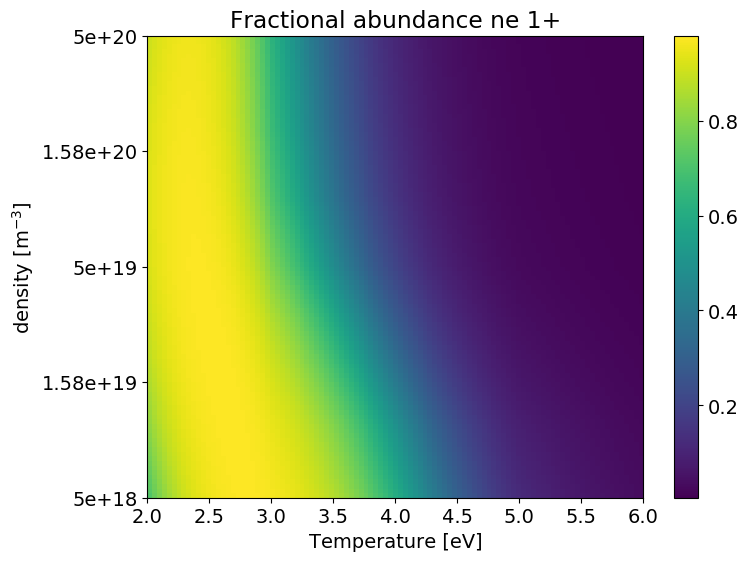

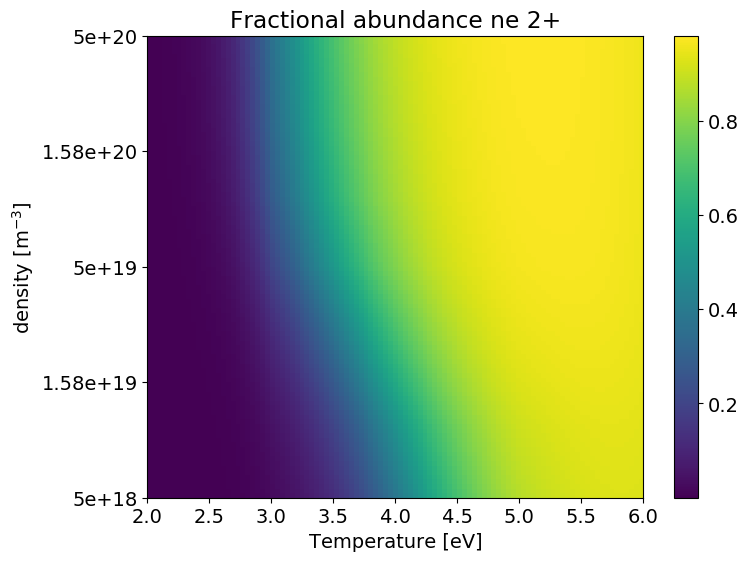

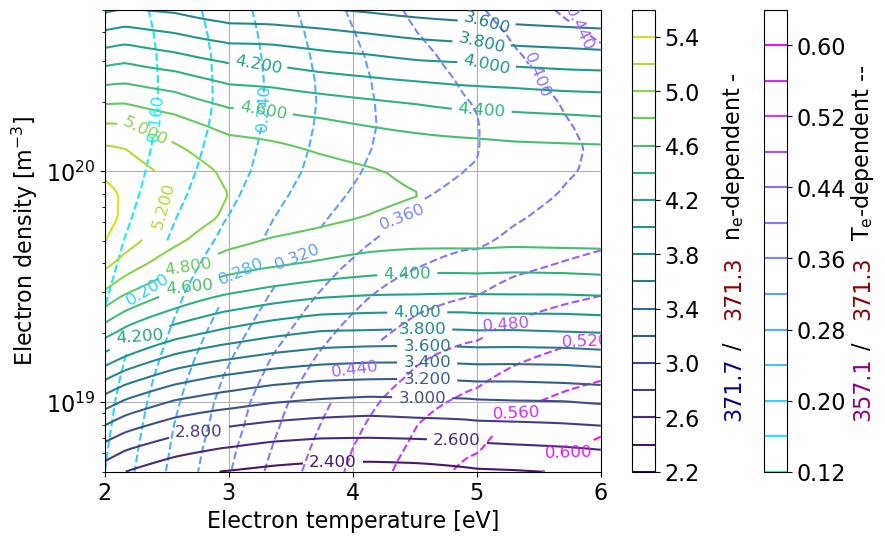

(100, 101)


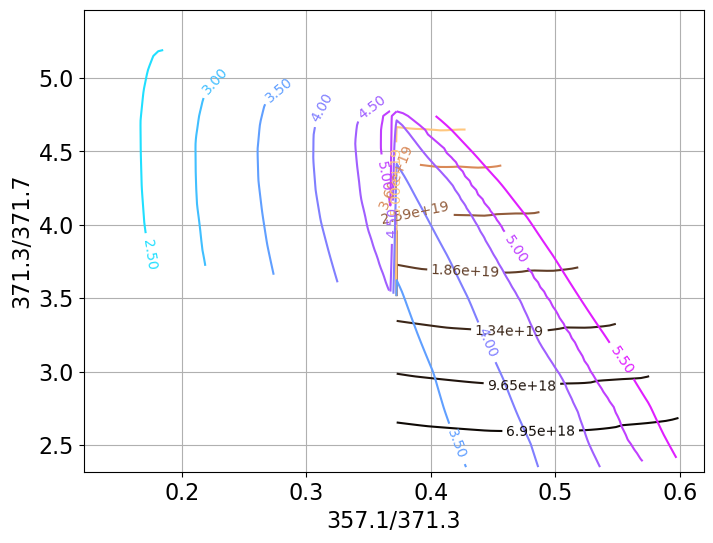

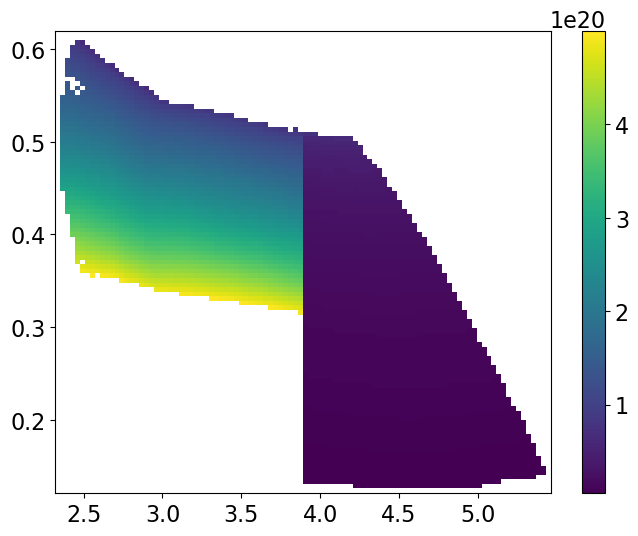

In [132]:
from divertor_spectroscopy import atomic_data
contourplot = True
if not contourplot:
    element = "ne"
    ne_count_ne= 6
    Te_count_ne = 100
    ne_count_Te = 100
    Te_count_Te = 6
    Te_range = [2,6]
    ne_range = [5e18,1e21]
    ne_scale = "log"
    use_recom = False
    debug = True
    ne_array_neon_Te, Te_array_neon_Te, frac_neon_Te, pecs_neon_Te, line_intensities_neon_Te = atomic_data.get_line_intensities(element=element,ne_count=ne_count_Te,ne_range=ne_range,ne_scale=ne_scale,Te_count=Te_count_Te,Te_range=Te_range,use_recom=use_recom,debug=debug)
    ne_array_neon_ne, Te_array_neon_ne, frac_neon_ne, pecs_neon_ne, line_intensities_neon_ne = atomic_data.get_line_intensities(element=element,ne_count=ne_count_ne,ne_range=ne_range,ne_scale=ne_scale,Te_count=Te_count_ne,Te_range=Te_range,use_recom=use_recom,debug=debug)
else:
    ne_scale = "log"
    use_recom = True
    if not use_recom:
        use_fractional_abundance = False
    else:
        use_fractional_abundance = True
    ne_array, Te_array, frac, pecs, line_intensities = atomic_data.get_line_intensities(element="ne",ne_range=[5e18,5e20],Te_range=[2,6],ne_scale=ne_scale,use_recom=use_recom,use_fractional_abundance=use_fractional_abundance,debug=True)
    line_ratio1_array = line_intensities[0]/line_intensities[1]
    line_ratio2_array = line_intensities[2]/line_intensities[1]
    importlib.reload(atomic_data)
    ratio1 = np.linspace(np.min(line_ratio1_array),np.max(line_ratio1_array),100)
    ratio2 = np.linspace(np.min(line_ratio2_array),np.max(line_ratio2_array),101)
    ne = np.zeros((len(ratio2),len(ratio1)))*np.nan
    Te = np.zeros((len(ratio2),len(ratio1)))*np.nan
    print(line_ratio1_array.shape)
    for ratio1_idx,r1 in enumerate(ratio1):
        for ratio2_idx,r2 in enumerate(ratio2):
            try:
                ne[ratio2_idx,ratio1_idx],Te[ratio2_idx,ratio1_idx] = atomic_data.get_ne_Te_from_tapete(line_ratio1_array=line_ratio1_array,line_ratio2_array=line_ratio2_array,ne_array=ne_array,Te_array=Te_array,line_ratio1_target=r1,line_ratio2_target=r2,ne_scale=ne_scale)
            except:
                pass
    plt.figure(figsize=(8,6))
    cs1 = plt.contour(ratio1,ratio2,ne,cmap="copper",levels=np.logspace(np.log10(5e18),np.log10(5e19),8))
    plt.clabel(cs1, inline=True, fontsize=10,fmt="%.2e")
    #plt.colorbar()
    cs2 = plt.contour(ratio1,ratio2,Te,cmap="cool")
    plt.clabel(cs2, inline=True, fontsize=10,fmt="%.2f")
    plt.ylabel("371.3/371.7")
    plt.xlabel("357.1/371.3")
    #plt.colorbar()
    plt.grid()
    plt.show()
    plt.figure(figsize=(8,6))
    plt.imshow(ne,aspect="auto",interpolation="none",extent=[ratio2[0],ratio2[-1],ratio1[0],ratio1[-1]],origin="lower")
    plt.colorbar()
    plt.show()


('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 1227 163390
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 59 163390
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 668 163390
('EJM', 'KJM', 'KKM', 'FTM', 'DAM'): 1227 163390


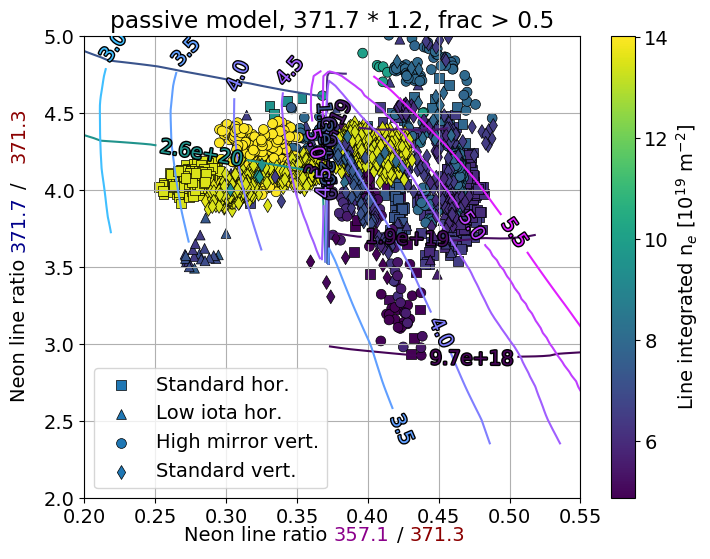

In [133]:
%matplotlib widget
%matplotlib inline
debugPlot = False
#debugPlot = True
AEF = True
if AEF:
    x = line_ratio_horizontal_AEF51_neII1
    x2 = line_ratio_vertical_AEF51_neII1
    y = line_ratio_horizontal_AEF51_neII2
    y2 = line_ratio_vertical_AEF51_neII2
    
    #z = impurity_concentration_horizontal_AEF51_neII
    #z2 = impurity_concentration_vertical_AEF51_neII
else:
    #x = line_ratio_horizontal_AEI51_neII2
    x2 = line_ratio_horizontal_AEI51_neII2
    #y = line_ratio_horizontal_AEI51_neII1
    y2 = line_ratio_horizontal_AEI51_neII1
    #z = impurity_concentration_horizontal_AEI51_neII
    #z2 = impurity_concentration_horizontal_AEI51_neII

#z = qss_max_intensities_horizontal_AEF51_Stark_density_H_delta
#z2 = qss_max_intensities_vertical_AEF51_Stark_density_H_delta
#z = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z2 = qss_brightest_channel_strikeline_Stark_density_H_gamma
z = lineDensity
z2 = lineDensity
#z = qss_average_intensities_AEF51_v1_Intensity_NeII_371_046
#z2 = qss_average_intensities_AEF51_v1_Intensity_NeII_371_046
#z = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z2 = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z = qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046
#z2 = qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046
#z = line_ratio_horizontal_AEF51_oII_to_neii_log
#z2 = line_ratio_vertical_AEF51_oII_to_neii_log
#z = time_inshot
#z2 = time_inshot
#z = pFraction
#z2 = pFraction
#z = control_coil_current
#z2 = control_coil_current
#z = GasInlet_divertor_Ne_voltage_times_pressure_integrated
#z2 = GasInlet_divertor_Ne_voltage_times_pressure_integrated


shot = "20230323.054"
#shot ='20230131.009'#,'20230131.008'
#shot = "20230118.030"
#shot2 = "20230118.050"
shot = "20241024.030"
shot = "20241212.080"
shot = "20230125.042"
shot = "20230222.015"
shot = "20241112.051"
shot = "20230323.054"
#shot = "20230315.054"
#shot = "20230118.027"
if False: 
    [ '20230131.011', '20230131.013',
       '20230131.014', '20230131.016', '20230131.021', '20230131.022',
       '20230131.024', '20230131.028', '20230131.033', '20230131.035',
       '20230131.036', '20230131.046', '20230131.054', '20230131.055']
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])
myShot2 = np.array([i.find("W7X"+shot2) >= 0 for i in juice['shot']])


markerSets2 = [ # vertical target
{ 'label':'High mirror vert.', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':50, 'edgecolor':'k',"linewidth":0.5},
{'label':'Standard vert.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 'd', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:]+" AEF", 'filter':myShot, 'marker' : 'o', 'size':100, 'edgecolor':'r',"linewidth":1},
#{ 'label':list(juice['shot'][myShot2])[0][3:], 'filter':myShot2, 'marker' : 's', 'size':100, 'edgecolor':'k'},
#{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
        ]
markerSets = [ # horizontal target
#{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
{ 'label':'Standard hor.', 'filter': np.array([i.startswith("E") for i in list(juice["configuration"])]) , 'marker' : 's', 'size':50, 'edgecolor':'k',"linewidth":0.5},
{ 'label':'Low iota hor.', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : '^', 'size':50, 'edgecolor':'k',"linewidth":0.5},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 's', 'size':100, 'edgecolor':'r'},
#{"label":shot,'filter':juice["shot"]=="W7X"+shot, 'marker' : '^', 'size':100, 'edgecolor':'r',"linewidth":1}
        ]
# filter data for cleaner plots
# negative filter with ~ in front♠
cfg = "EJM", "KJM", "KKM", "FTM", "DAM"
#cfg = "E"
#cfg = "EJM"
isCfg = np.array([i.startswith(cfg) for i in list(juice["configuration"])])    
is_forward_field = np.array(["+" in i for i in list(juice["configuration"])]) 
wo_nbi = ~np.array([i>0 for i in list(juice["shot_with_nbi"])])
he_shots = np.array([i<0.8 for i in list(juice["h_to_he_corrected"])])
#he_shots = np.array([i==True for i in list(juice["shot_with_main_he_injection"])])
#h2_shots = np.array([i==True for i in list(juice["shot_with_main_h2_injection"])])

#slowchange_neL = np.abs(juice["dneL_dt_1e19_m2_s"])<3
#wImpurity_Seeding_He = np.array([i>0 for i in list(juice["shot_with_divertor_He_injection"])])
#wImpurity_Seeding_Ne = np.array([i>0 for i in list(juice["shot_with_divertor_Ne_injection"])])
#wImpurity_Seeding_Ar = np.array([i>0 for i in list(juice["shot_with_divertor_Ar_injection"])])
#wImpurity_Seeding_N2 = np.array([i>0 for i in list(juice["shot_with_divertor_N2_injection"])])
#wImpurity_Seeding = wImpurity_Seeding_Ne | wImpurity_Seeding_Ar | wImpurity_Seeding_N2
#nitrogen_intensity_cutoff = 40
#neon_intensity_cutoff = 10
flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #&(4*AEI51_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI51_qss_intensities_exp_Intensity_CIII_674_063["data"])
        #&(juice["neL_1e19_m2"] > 7.5)
        #&(juice["neL_1e19_m2"] > 10)
        #&(juice["neL_1e19_m2"] < 12)
        & (total_power["data"]>2)
        #& (line_ratio_horizontal_AEF51_neII1["data"]<0.37)
        #& (total_power["data"]>3.5)
        #& (total_power["data"]<4.5)
        #& (power_nbi["data"]<1)
        #& (lineDensity["data"]>5.5)
        #& (lineDensity["data"]<6.5)
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        #& ~is_forward_field
        #& (pFraction["data"] > 0.1)
        & (pFraction["data"] > 0.5)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
        #& h2_shots
        #& ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        &(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #&(juice["t_in_shot"] > 12)
        #&(juice["t_in_shot"] < 14)
        
        #& (total_power["data"]>2.5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& ~wImpurity_Seeding_Ar
        #& ~wImpurity_Seeding_He
        &(GasInlet_qsq_Ne_gas_amount_integrated["data"]>10)  # 200
        & ((qss_max_intensities_AEF51_horizontal_v_neon1_Intensity_NeII_371_046["data"]>250)|(qss_max_intensities_AEF51_vertical_v_neon1_Intensity_NeII_371_046["data"]>500))
        #& ((balmer_delta_intensity_horizontal["data"] > 1e16) | (balmer_delta_intensity_vertical["data"] > 1e16))
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        #& (line_ratio_horizontal_AEF51_h_to_he["data"]>20) # this takes out he main gas discharges
        #& ~(qss_max_intensities_log_vertical_AEF51_Intensity_HeI_396_473["data"]>15.25)
        #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_046["data"]>20)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_401_386["data"]>10)
        
        #((qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_046["data"]>10) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046["data"]>10))
        #& wImpurity_Seeding_Ne
        #& ((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff))
        #& ~((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff) & (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff))
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046["data"]>neon_intensity_cutoff) # vertical target
        #& (qss_average_intensities_AEF51_v1_Intensity_NeII_371_046["data"]>10)        
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        #& (control_coil_current["data"]<0.5)
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to

#debug_selection = [x2,y2,z2,markerSets2[0]]
debug_selection = [x,y,z,markerSets[0]]
fltSel = flt & np.isfinite(debug_selection[0]['data'])& np.isfinite(debug_selection[1]['data'])& np.isfinite(debug_selection[2]['data']) & debug_selection[3]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((debug_selection[0]['data'][flt] - event.xdata)**2 + (debug_selection[1]['data'][flt] - event.ydata)**2)
    xx = np.array(debug_selection[0]['data'][flt])[j]
    yy = np.array(debug_selection[1]['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
        
if True:
        x["max"] = np.nanmax(debug_selection[0]["data"][fltSel])
        y["max"] = np.nanmax(debug_selection[1]["data"][fltSel])
        z["max"] = np.nanmax(debug_selection[2]["data"][fltSel])
        x["min"] = np.nanmin(debug_selection[0]["data"][fltSel])
        y["min"] = np.nanmin(debug_selection[1]["data"][fltSel])
        z["min"] = np.nanmin(debug_selection[2]["data"][fltSel])
x["min"] = 0.2
x["max"] = 0.55
y["min"] = 2  # 0.2
y["max"] = 5.
#z["min"] = 0
#z["max"] = 10

#z["min"] = 3
#z["max"] = 14
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'], linewidth = markerSet['linewidth'], label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z2['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z2['data'][i]
        print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = markerSet['linewidth'], label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()

yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if True:
    utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred",],axis="x")
    utils.multicolor_ylabel(ax,["Neon line ratio","371.7","/","371.3"],list_of_colors=["darkred","black","darkblue","black",],axis="y")

else: 
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

if False:
    for boronization in plasma_exposure_times_of_boronizations:
        plt.axvline(boronization, color='r', linestyle='--')
plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if True:
    plt.legend() 
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])   
#plt.title("Stark Density")
#plt.ylabel("Stark density [10$^{19}$ m$^{-3}$]")
if True:
    if not contourplot:
        for T_idx,T in enumerate(Te_array_neon_Te):
            y = line_intensities_neon_Te[1,:,T_idx]/line_intensities_neon_Te[2,:,T_idx]
            x = line_intensities_neon_Te[0,:,T_idx]/line_intensities_neon_Te[1,:,T_idx]
            label="{:.1f}".format(T)
            
            plt.plot(x,y,label=label,color = colors[T_idx],ls="--")
            placement = 0.1#0.2
            plt.text(x[int(len(x)*placement)], y[int(len(y)*placement)], label, va='center',color=colors[T_idx])
        for n_idx,n in enumerate(ne_array_neon_ne):
            y = line_intensities_neon_ne[1,n_idx]/line_intensities_neon_ne[2,n_idx]
            x = line_intensities_neon_ne[0,n_idx]/line_intensities_neon_ne[1,n_idx]
            label="{:.1e}".format(n)
            plt.plot(x,y,label=label,color = colors[n_idx+6])
            placement = 0.24# 0.9
            plt.text(x[int(len(x)*placement)], y[int(len(y)*placement)], label, va='center',color=colors[n_idx+6])
    else:
        levels = np.logspace(np.log10(5e18),np.log10(50e19),8)
        #levels = np.linspace(5e18,50e19,8)
        #levels = [6e18,1e19,1.5e19,2e19,2.5e19]
        #levels = None
        cs1 = ax.contour(ratio1, ratio2, ne, cmap="viridis", levels=levels)
        clabels1 = ax.clabel(cs1, inline=True, fontsize=14, fmt="%.1e")
        # Weiße Umrandung für bessere Lesbarkeit
        for txt in clabels1:
            txt.set_path_effects([path_effects.withStroke(linewidth=2, foreground="black")])
        cs2 = ax.contour(ratio1,ratio2,Te,cmap="cool")
        clabels2 = ax.clabel(cs2, inline=True, fontsize=14,fmt="%.1f")
        for txt in clabels2:
            txt.set_path_effects([path_effects.withStroke(linewidth=2, foreground="black")])
if False:
    x_vals = np.array(ax1.get_xlim())
    y_vals1 = 10.5 * x_vals
    y_vals2 = 8.7 * x_vals
    y_vals1 = 0.1 * x_vals
    y_vals2 = 0.2 * x_vals
    
    ax1.plot(x_vals, y_vals1, '--', color='orange',label=r"n$_{\mathrm{e}}=1 \times 10^{19} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$3eV")
    ax1.plot(x_vals, y_vals2, '--', color='red',label=r"n$_{\mathrm{e}}=1 \times 10^{20} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$4eV")
#plt.yscale("log")
#plt.xscale("log")
#plt.legend(loc="lower right")
plt.title("passive model, 371.7 * 1.2, frac > 0.5")
if True:
    save_title = "Juice_ne_ratio1_ne_ratio2_line_density_all_data"
    save_title = "Juice_ne_ratio1_ne_ratio2_line_density_low_density"
    save_title = "Juice_ne_ratio1_ne_ratio2_line_density_high_density"
    save_title = "Juice_ne_ratio1_ne_ratio2_concentration_high_density"
    #save_title = "Juice_ne_ratio1_ne_ratio2_concentration_low_density"
    #save_title = "Juice_ne_ratio1_ne_ratio2_times_1.1_concentration_low"
    #save_title = "Juice_ne_ratio1_ne_ratio2_times_1.1_concentration_high_density"
    #save_title = "Juice_ne_ratio1_ne_ratio2_stark_density_all_data"
    
    #save_title = "Juice_ne_ratio1_ne_ratio2_frad_all_data"
if not debugPlot:
    save_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/05_radiation_dynamics/"
    #save_path = None
    if save_path is not None:
                #plt.tight_layout()
                plt.savefig(save_path+save_title+".pdf")
                plt.savefig(save_path+save_title+".png",dpi=400)
    plt.show()

In [ ]:
importlib.reload(atomic_data)
line_intensity1 = 1.686e17
line_intensity2 = 4.324e17
line_intensity3 = 1.383e18
ne,Te,nNe = atomic_data.get_ne_Te_nNe_from_tapete(ne_array=ne_array,Te_array=Te_array,line_intensity_array=line_intensities,line_intensity1=line_intensity1,line_intensity2=line_intensity2,line_intensity3=line_intensity3,ne_scale=ne_scale)
print(ne,Te,nNe)
print("Concentration = {}".format(100*nNe/ne))

1.230092830735698e+19 3.411748116212819 4.285687040672669e+19
Concentration = 348.40354594290835


2025-01-22 13:38:37,298 - divertor_spectroscopy.utilities - DEBUG - Folder '//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/20230125/20230125.045/Plots' already exists.
2025-01-22 13:38:37,307 - divertor_spectroscopy.utilities - DEBUG - Folder '//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/qss_analysis/discharges/OP2.1/20230125/20230125.045/Plots/AEI51' already exists.


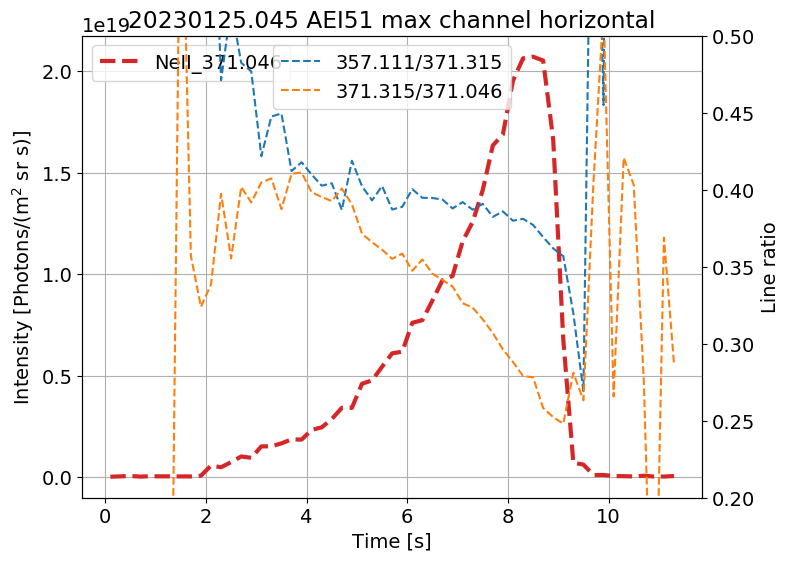

In [ ]:
if True:
    %matplotlib inline
    importlib.reload(qss_juice)
    shotname = "20241212.080"
    shotname = "20230125.045"
    strikeline = "vertical"
    strikeline = "horizontal"
    debug = True
    debug_parameters = ["Intensity_NII_399.500"]
    debug_parameters = ["Intensity_NII_402.683"]
    #debug_parameters = ["Intensity_NII_404.098"]
    debug_parameters = ["Intensity_NII_399.500","Intensity_NII_402.683","Intensity_NII_404.098"]
    debug_parameters = ["Intensity_HI_410.173","Intensity_CII_407.528","Intensity_CIII_406.926"]
    debug_parameters = ["Intensity_NeII_357.111","Intensity_NeII_371.315","Intensity_NeII_371.046",]
    debug_parameters = ["Intensity_NeII_371.046"]
    #debug_parameters = ["Stark_density_H_delta","Stark_density_H_epsilon"]
    port = "AEI51"
    #port = "AEI51"
    #port = "AEI30"
    camids = ["IP320_5"]
    camids = ["IP320_3"]
    #+camids = ["IP320_1"]
    central_wavelengths = ["364"]#,"405"]
    version = "_recalibration"
    #version = "2"
    average = "25"
    version = "_neon1"
    #version = "_stark1"
    average = "200"
    #debug_parameters = None
    plot_line_ratios = [["Intensity_NII_404.098","Intensity_NII_402.683"],["Intensity_NII_404.098","Intensity_NII_399.500"]]
    plot_line_ratios = [["Intensity_NII_404.098","Intensity_NII_399.500"]]
    plot_line_ratios = [["Intensity_HI_397.007","Intensity_HI_410.173"]]
    #plot_line_ratios = [["Intensity_NII_404.098","Intensity_NII_402.683"]]
    plot_line_ratios = [["Intensity_NeII_357.111","Intensity_NeII_371.315"],["Intensity_NeII_371.315","Intensity_NeII_371.046"]]
    plot_channels = False
    #xlim = [2.9,8]
    xlim = None
    intensities,description = qss_juice.get_qss_max_intensities(shotname=shotname,average=average,port=port,central_wavelengths=central_wavelengths,camids=camids,version=version,strikeline=strikeline,debug=debug,debug_parameters=debug_parameters,plot_line_ratios=plot_line_ratios,plot_channels=plot_channels,xlim=xlim)

### The line ratios alone do not lead to the correct ratios - we have to implement density and Temperature inputs from elsewhere
- density from Stark broadening
- Temeprature as an assumption

In [ ]:
asdf

NameError: name 'asdf' is not defined

### Nitrogen

In [ ]:
juice.columns

Index(['shot', 't1', 't_shot_start', 't_shot_stop', 't_in_shot', 'time_step',
       'campaign', 'postboronization', 'w7xdia_version', 'archivedb_version',
       ...
       'qss_brightest_channel_strikeline_Intensity_NIII_409.937',
       'qss_brightest_channel_strikeline_Intensity_ArII_410.383',
       'qss_brightest_channel_strikeline_Intensity_ArII_410.391',
       'qss_brightest_channel_strikeline_Intensity_H_delta',
       'qss_brightest_channel_strikeline_Stark_density_H_delta',
       'qss_brightest_channel_strikeline_Doppler_shift_H_delta',
       'qss_brightest_channel_strikeline_Intensity_OII_396.697',
       'qss_brightest_channel_strikeline_Intensity_ArII_396.836',
       'qss_brightest_channel_strikeline_Intensity_H_epsilon',
       'qss_brightest_channel_strikeline_Stark_density_H_epsilon'],
      dtype='object', length=712)

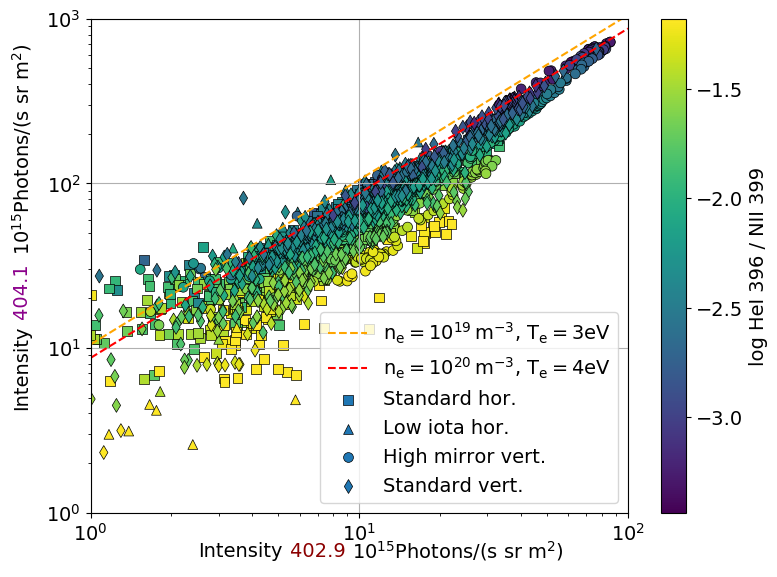

In [ ]:
%matplotlib widget
%matplotlib inline
debugPlot = True
debugPlot = False

if False:
    x = qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_399_500
    x2 = qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_399_500
    y = qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_404_098
    y2 = qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_404_098
else:
    x = qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_402_683
    x2 = qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_402_683
    y = qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_404_098
    y2 = qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_404_098
z = lineDensity
z2 = lineDensity
z = line_ratio_horizontal_AEF51_heI_to_nii_log
z2 = line_ratio_vertical_AEF51_heI_to_nii_log
shot = "20230323.054"
#shot = "20230222.013"
#shot = "20230118.030"
#shot = "20230222.015"
#shot = "20230118.050"
#shot = "20230209.019"
#shot = "20230315.058"
#shot = "20230125.033"
#shot = "20230125.049"
#shot = "20230209.018"
#shot = "20221207.016"
#shot = "20230118.033"
#shot ='20230131.009'#,'20230131.008'
shot = "20241024.024"
shot2 = "20230118.050"
if False: 
    [ '20230131.011', '20230131.013',
       '20230131.014', '20230131.016', '20230131.021', '20230131.022',
       '20230131.024', '20230131.028', '20230131.033', '20230131.035',
       '20230131.036', '20230131.046', '20230131.054', '20230131.055']
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])
myShot2 = np.array([i.find("W7X"+shot2) >= 0 for i in juice['shot']])


markerSets2 = [ # vertical target
{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])])), 'marker' : 'o', 'size':50, 'edgecolor':'k'},
{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])])) , 'marker' : 'd', 'size':50, 'edgecolor':'k'},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : 'o', 'size':50, 'edgecolor':'k'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")) , 'marker' : 'd', 'size':50, 'edgecolor':'k'},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : 'o', 'size':50, 'edgecolor':'w'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")) , 'marker' : 'd', 'size':50, 'edgecolor':'w'},
#{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':100, 'edgecolor':'k'},
#{ 'label':list(juice['shot'][myShot2])[0][3:], 'filter':myShot2, 'marker' : 's', 'size':100, 'edgecolor':'k'},
#{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
        ]
markerSets = [ # horizontal target
#{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])])), 'marker' : 's', 'size':50, 'edgecolor':'k'},
{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])])), 'marker' : '^', 'size':50, 'edgecolor':'k'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : 's', 'size':50, 'edgecolor':'k'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : '^', 'size':50, 'edgecolor':'k'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : 's', 'size':50, 'edgecolor':'w'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : '^', 'size':50, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : '^', 'size':100, 'edgecolor':'k'},
#{"label":shot,'filter':juice["shot"]=="W7X"+shot, 'marker' : 'd', 'size':100, 'edgecolor':'k'}
        ]

flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #&(4*AEI51_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI51_qss_intensities_exp_Intensity_CIII_674_063["data"])
        #&(juice["neL_1e19_m2"] > 6.5)
        #&(juice["neL_1e19_m2"] < 7.5)
        #&(juice["neL_1e19_m2"] < 12)
        & (total_power["data"]>2)
        #& (total_power["data"]>3.5)
        #& (total_power["data"]<4.5)
        #& (power_nbi["data"]<1)
        #& (lineDensity["data"]>5.5)
        #& (lineDensity["data"]<6.5)
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        #& ~is_forward_field
        #& (pFraction["data"] < 0.8)
        #& (pFraction["data"] > 0.3)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
        #& h2_shots
        #& ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        &(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #& (total_power["data"]>2.5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& ~wImpurity_Seeding_Ar
        #& ~wImpurity_Seeding_He
        #&(GasInlet_qsq_N2_voltage_times_pressure_integrated["data"]>70)
        #&(GasInlet_qsq_He_voltage_times_pressure["data"]<1)
        & (GasInlet_qsq_N2_gas_amount_integrated["data"]>1)
        #& ((balmer_delta_intensity_horizontal["data"] > 1e16) | (balmer_delta_intensity_vertical["data"] > 1e16))
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        #& (line_ratio_horizontal_AEF51_h_to_he["data"]>20) # this takes out he main gas discharges
        #& ~(qss_max_intensities_log_vertical_AEF51_Intensity_HeI_396_473["data"]>15.25)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>10)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_401_386["data"]>10)
        
        #((qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>100) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_755["data"]>100))
        #& wImpurity_Seeding_Ne
        #& ((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff))
        #& ~((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff) & (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff))
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046["data"]>neon_intensity_cutoff) # vertical target
        #& (juice_qss_average_intensities_Intensity_AEF51_NeII_371_755["data"] > 10)
        #& (juice_qss_average_intensities_Intensity_AEF51_NII_399_500["data"] > 10)
        
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to

debug_selection = [x2,y2,z2,markerSets2[0]]
#debug_selection = [x,y,z,markerSets[0]]
fltSel = flt & np.isfinite(debug_selection[0]['data'])& np.isfinite(debug_selection[1]['data'])& np.isfinite(debug_selection[2]['data']) & debug_selection[3]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((debug_selection[0]['data'][flt] - event.xdata)**2 + (debug_selection[1]['data'][flt] - event.ydata)**2)
    xx = np.array(debug_selection[0]['data'][flt])[j]
    yy = np.array(debug_selection[1]['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
        
if True:
        x["max"] = np.nanmax(debug_selection[0]["data"][fltSel])
        y["max"] = np.nanmax(debug_selection[1]["data"][fltSel])
        z["max"] = np.nanmax(debug_selection[2]["data"][fltSel])
        x["min"] = np.nanmin(debug_selection[0]["data"][fltSel])
        y["min"] = np.nanmin(debug_selection[1]["data"][fltSel])
        z["min"] = np.nanmin(debug_selection[2]["data"][fltSel])
x["min"] = 1
x["max"] = 100
y["min"] = 1
y["max"] = 1000
#z["min"] = 0.25
#z["max"] = 0.5

#z["min"] = 3
#z["max"] = 10
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    #print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z2['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z2['data'][i]
        #print("%s: %i %i" % (cfg, i.sum(), isCfg.sum()))
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])
yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if True:
    utils.multicolor_ylabel(ax,["Intensity","404.1","$10^{15}$Photons/(s sr m$^2$)"],list_of_colors=["black","darkmagenta","black"],axis="y")
    utils.multicolor_ylabel(ax,["Intensity","402.9","$10^{15}$Photons/(s sr m$^2$)"],list_of_colors=["black","darkred","black"],axis="x")
else: 
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

if False:
    for boronization in plasma_exposure_times_of_boronizations:
        plt.axvline(boronization, color='r', linestyle='--')
plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if True:
    plt.legend() 
    
#plt.title("Stark Density")
#plt.ylabel("Stark density [10$^{19}$ m$^{-3}$]")
plt.tight_layout()
if False:
    for T_idx,T in enumerate(Te_array):
        plt.plot(line_intensities[2,:,T_idx]/line_intensities[1,:,T_idx],line_intensities[2,:,T_idx]/line_intensities[0,:,T_idx],label="{} eV".format(T))
if True:
    x_vals = np.array(ax1.get_xlim())
    y_vals1 = 10.5 * x_vals
    
    y_vals2 = 8.7 * x_vals
    #y_vals1 = 0.1 * x_vals
    #y_vals2 = 0.25 * x_vals
    
    ax1.plot(x_vals, y_vals1, '--', color='orange',label=r"n$_{\mathrm{e}}=10^{19} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$3eV")
    ax1.plot(x_vals, y_vals2, '--', color='red',label=r"n$_{\mathrm{e}}=10^{20} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$4eV")
plt.yscale("log")
plt.xscale("log")
plt.legend()
if True:
    nitrogen_version = "_nitrogen4"
    if nitrogen_version == "_nitrogen1":
        plt.title("NII and ArII lines")
        save_title = "Juice_399_404_version"+nitrogen_version
    if nitrogen_version == "_nitrogen2":
        plt.title("Only fitted strongest part of 404.1 multiplet")
        save_title = "Juice_399_404_version"+nitrogen_version
    if nitrogen_version == "_nitrogen3":
        plt.title("Added OII lines")
        save_title = "Juice_399_404_version"+nitrogen_version
    if nitrogen_version == "_nitrogen4":
        #plt.title("Added HeI line")
        save_title = "Juice_402_404_version"+nitrogen_version
    if nitrogen_version == "_nitrogen5":
        plt.title("Numeric instrument function, no zeeman effect")
        save_title = "Juice_399_404_version"+nitrogen_version


    if not debugPlot:
        save_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/05_radiation_dynamics/"
        #save_path = None
        if save_path is not None:
                    plt.tight_layout()
                    plt.savefig(save_path+save_title+".pdf")
                    plt.savefig(save_path+save_title+".png",dpi=400)
        plt.show()
else:
    if not debugPlot:
        plt.show()

In [ ]:
from divertor_spectroscopy import atomic_data
element = "n"
ne_count_ne= 6
Te_count_ne = 100
ne_count_Te = 100
Te_count_Te = 6
Te_range = [2,6]
ne_range = [1e19,10e20]
ne_scale = "linear"
debug = False
ne_array_nitrogen_Te, Te_array_nitrogen_Te, frac_nitrogen_Te, pecs_nitrogen_Te, line_intensities_nitrogen_Te = atomic_data.get_line_intensities(element=element,ne_count=ne_count_Te,ne_range=ne_range,ne_scale=ne_scale,Te_count=Te_count_Te,Te_range=Te_range,debug=debug)
ne_array_nitrogen_ne, Te_array_nitrogen_ne, frac_nitrogen_ne, pecs_nitrogen_ne, line_intensities_nitrogen_ne = atomic_data.get_line_intensities(element=element,ne_count=ne_count_ne,ne_range=ne_range,ne_scale=ne_scale,Te_count=Te_count_ne,Te_range=Te_range,debug=debug)


2025-01-16 14:44:04,256 - divertor_spectroscopy.atomic_data - DEBUG - indices: [14, 18, 20, 64, 68, 70]
2025-01-16 14:44:05,193 - divertor_spectroscopy.atomic_data - INFO - 10.0 % done
2025-01-16 14:44:05,774 - divertor_spectroscopy.atomic_data - INFO - 20.0 % done
2025-01-16 14:44:06,214 - divertor_spectroscopy.atomic_data - INFO - 30.0 % done
2025-01-16 14:44:06,669 - divertor_spectroscopy.atomic_data - INFO - 40.0 % done
2025-01-16 14:44:07,130 - divertor_spectroscopy.atomic_data - INFO - 50.0 % done
2025-01-16 14:44:07,591 - divertor_spectroscopy.atomic_data - INFO - 60.0 % done
2025-01-16 14:44:08,079 - divertor_spectroscopy.atomic_data - INFO - 70.0 % done
2025-01-16 14:44:08,569 - divertor_spectroscopy.atomic_data - INFO - 80.0 % done
2025-01-16 14:44:09,205 - divertor_spectroscopy.atomic_data - INFO - 90.0 % done
2025-01-16 14:44:09,612 - divertor_spectroscopy.atomic_data - DEBUG - indices: [14, 18, 20, 64, 68, 70]


In [ ]:
%matplotlib widget
#%matplotlib inline
debugPlot = False
debugPlot = True
#z2 = pRad
x = power_target
x2 = power_target
x = pFraction
x2 = pFraction
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_711_798
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_CII_711_798
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_BII_412_193
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensityensity_BII_412_193
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_360_934
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_CIII_360_934
##x = qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_667_815
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_HeI_667_815
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_402_683
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensityensity_NII_402_683

#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_402_683
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NII_402_683
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_410_391
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_ArII_410_391
#x = plasma_exposure_time
#x2 = plasma_exposure_time
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_357_111
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensityensityensity_NeII_357_111
#x = line_ratio_horizontal_AEF51_neII1
#x2 = line_ratio_vertical_AEF51_neII1
#x = line_ratio_horizontal_AEF51_nII2_v_nitrogen4
#x2 = line_ratio_vertical_AEF51_nII2_v_nitrogen4
x = pFraction
x2 = pFraction

#y = qss_strikeline_positions_horizontal_Intensity_Balmer_H_delta
#y2 = qss_strikeline_positions_vertical_Intensity_Balmer_H_delta
#y = qss_strikeline_positions_horizontal_Intensity_Balmer_H_epsilon
#y2 = qss_strikeline_positions_vertical_Intensity_Balmer_H_epsilon

#y = qss_strikeline_positions_horizontal_Intensity_CII_407_528
#y2 = qss_strikeline_positions_vertical_Intensity_CII_407_528
#y = qss_strikeline_positions_horizontal_Intensity_CIII_406_926
#y2 = qss_strikeline_positions_vertical_Intensity_CIII_406_926
#
#y = qss_strikeline_positions_horizontal_Intensity_NIII_409_937
#y2 = qss_strikeline_positions_vertical_Intensity_NIII_409_937

#y = qss_strikeline_positions_horizontal_Intensity_NeII_371_755
#y2 = qss_strikeline_positions_vertical_Intensity_NeII_371_755

#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_BII_703_200
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_BII_703_200
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_CIII_406_926
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_CIII_406_926
#y = line_ratio_horizontal_AEF51_cIII
#y2 = line_ratio_vertical_AEF51_cIII
#y = line_ratio_horizontal_AEF51_h_to_he
#y = line_ratio_vertical_AEF51_h_to_he
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_706_519
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_HeI_706_519
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_404_098
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NII_404_098
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_401_386
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensityensity_ArII_401_386
y = line_ratio_horizontal_AEF51_nII1_v_nitrogen4
y2 = line_ratio_vertical_AEF51_nII1_v_nitrogen4
#y = line_ratio_horizontal_AEF51_neII2
#y2 = line_ratio_vertical_AEF51_neII2
#y = line_ratio_horizontal_AEF51_oII_to_cII
#y2 = line_ratio_vertical_AEF51_oII_to_cII
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_396_697
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_OII_396_697
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_NeII_371_315
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_357_111
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_NeII_357_111
#y = AEI51_qss_positions_radiation_front_Intensity_CIII_674_063
#y2 = AEI51_qss_positions_radiation_front_Intensity_CIII_674_063


#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_678_591
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensityensityensity_CII_678_591
#y = qss_positions_radiation_front_Intensity_CIII_360_934
#y2 = qss_positions_radiation_front_Intensity_CIII_674_063
#y2 = qss_positions_radiation_front_Intensity_CII_678_591


z2 = lineDensity
z = lineDensity
#z = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z2 = qss_brightest_channel_strikeline_Stark_density_H_gamma
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_HeI_396_473
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_HeI_396_473
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensityensityensity_NeII_371_315
#z = juice_qss_average_intensities_Intensity_AEF51_NeII_371_755
#z2 = juice_qss_average_intensities_Intensity_AEF51_NeII_371_755
#z = pFraction
#z2 = pFraction
#z = qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_399_500
#z2 = qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_399_500
#z = GasInlet_divertor_He_voltage_times_pressure_integrated
#z2 = GasInlet_divertor_He_voltage_times_pressure_integrated
#z = qss_max_intensities_log_horizontal_AEF51_Intensity_OII_396_697
#z2 = qss_max_intensities_log_vertical_AEF51_Intensity_OII_396_697
#z = line_ratio_horizontal_AEF51_oII_to_nii_log
#z2 = line_ratio_vertical_AEF51_oII_to_nii_log
#z = line_ratio_horizontal_AEF51_cII_to_nii_log
#z2 = line_ratio_vertical_AEF51_cII_to_nii_log
#z = line_ratio_horizontal_AEF51_heI_to_nii_log
#z2 = line_ratio_vertical_AEF51_heI_to_nii_log
#z = total_power
#z2 = total_power
#z = power
#z2 = power
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_BII_412_193
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensityensity_BII_412_193

#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_OII_373_597
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensity_OII_373_597
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_372_934
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensity_ArII_372_934
#z = qss_max_intensities_log_horizontal_AEF51_Intensity_NII_399_500
#z2 = qss_max_intensities_log_vertical_AEF51_Intensity_NII_399_500
#z = qss_max_intensities_log_horizontal_AEF51_Intensity_NeII_371_046
#z2 = qss_max_intensities_log_horizontal_AEF51_Intensity_NeII_371_046
#z = lineDensity
#z2 = lineDensity
#z = time_inshot
#z2 = time_inshot
#z = pFraction
#z2 = pFraction
#z = qss_max_intensities_log_horizontal_AEF51_Intensity_HeI_396_473
#z2 = qss_max_intensities_log_vertical_AEF51_Intensity_HeI_396_473
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_407_528
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensity_CII_407_528
#z = line_ratio_horizontal_AEF51_balmer_epsilon_delta
#z2 = line_ratio_vertical_AEF51_balmer_epsilon_delta
#z = qss_max_intensities_AEF51_horizontal_v1_Intensity_CII_407_528
#z2 = qss_max_intensities_AEF51_vertical_v1_Intensity_CII_407_528

#z = plasma_exposure_time
#z2 = plasma_exposure_time
#z = Ip
#z2 = Ip
#z = stark_density_horizontal
#z2 = stark_density_vertical
#z = stark_density_horizontal
#x = plasma_exposure_time
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_755
#x = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_315
#x2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_315
#y = qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_357_111
#y2 = qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_357_111
#z = pFraction
#z = control_coil_current

shot = "20230323.054"
#shot = "20230222.013"
#shot = "20230118.030"
#shot = "20230222.015"
#shot = "20230118.050"
#shot = "20230209.019"
#shot = "20230315.058"
#shot = "20230125.033"
#shot = "20230125.049"
#shot = "20230209.018"
#shot = "20221207.016"
#shot = "20230118.033"
#shot ='20230131.009'#,'20230131.008'
shot = "20230118.030"
shot2 = "20230125.049"
shot = "20241016.021"
if False: 
    [ '20230131.011', '20230131.013',
       '20230131.014', '20230131.016', '20230131.021', '20230131.022',
       '20230131.024', '20230131.028', '20230131.033', '20230131.035',
       '20230131.036', '20230131.046', '20230131.054', '20230131.055']
myShot = np.array([i.find("W7X"+shot) >= 0 for i in juice['shot']])
myShot2 = np.array([i.find("W7X"+shot2) >= 0 for i in juice['shot']])


markerSets2 = [ # vertical target
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])])), 'marker' : 'o', 'size':50, 'edgecolor':'k'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])])) , 'marker' : 'd', 'size':50, 'edgecolor':'k'},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : 'o', 'size':50, 'edgecolor':'k'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")) , 'marker' : 'd', 'size':50, 'edgecolor':'k'},
#{ 'label':'High mirror vert.', 'filter': (np.array([i.startswith("K") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : 'o', 'size':50, 'edgecolor':'w'},
#{'label':'Standard vert.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")) , 'marker' : 'd', 'size':50, 'edgecolor':'w'},
#{ 'label':'D', 'filter': np.array([i.startswith("D") for i in list(juice["configuration"])]) , 'marker' : 'x', 'size':25, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : 'd', 'size':200, 'edgecolor':'k'},
#{ 'label':list(juice['shot'][myShot2])[0][3:], 'filter':myShot2, 'marker' : 's', 'size':100, 'edgecolor':'k'},
#{"label":" ",'filter':juice["shot"]=="W7X"+"20230323.054", 'marker' : 'd', 'size':25, 'edgecolor':'w'}
        ]
markerSets = [ # horizontal target
#{ 'label':'K', 'filter': np.array([i.startswith("K") for i in list(juice["configuration"])]) , 'marker' : 'o', 'size':25, 'edgecolor':'w'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])])), 'marker' : 's', 'size':50, 'edgecolor':'k'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])])), 'marker' : '^', 'size':50, 'edgecolor':'k'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : 's', 'size':50, 'edgecolor':'k'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op21")), 'marker' : '^', 'size':50, 'edgecolor':'k'},
#{ 'label':'Standard hor.', 'filter': (np.array([i.startswith("E") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : 's', 'size':50, 'edgecolor':'w'},
#{ 'label':'Low iota hor.', 'filter': (np.array([i.startswith("D") for i in list(juice["configuration"])]) & np.array(juice["campaign"]=="op22")), 'marker' : '^', 'size':50, 'edgecolor':'w'},
#{ 'label':list(juice['shot'][myShot])[0][3:], 'filter':myShot, 'marker' : '^', 'size':100, 'edgecolor':'k'},
#{"label":shot,'filter':juice["shot"]=="W7X"+shot, 'marker' : 'd', 'size':100, 'edgecolor':'k'}
        ]
nitrogen_intensity_cutoff = 500
flt = (#(juice['ecrh_total_MW'] > .1) # ECRH data available and sensible
        (juice["neL_1e19_m2"] > 0.25) # density data available
        #&(4*AEI51_qss_intensities_radiation_front_Intensity_CIII_674_063["data"]>AEI51_qss_intensities_exp_Intensity_CIII_674_063["data"])
        #&(juice["neL_1e19_m2"] > 6.5)
        #&(juice["neL_1e19_m2"] < 7.5)
        #&(juice["neL_1e19_m2"] < 12)
        & (total_power["data"]>2)
        #& (total_power["data"]>3.5)
        #& (total_power["data"]<4.5)
        #& (power_nbi["data"]<1)
        #& (lineDensity["data"]>5.5)
        #& (lineDensity["data"]<6.5)
        #& isAfter_firstBoron
        #& isCfg # defined magnetic configuration
        #& ~is_forward_field
        #& (pFraction["data"] < 0.8)
        #& (pFraction["data"] > 0.3)
        #& ~(wo_nbi) #without NBI
        #& (power_nbi["data"]>.1)
        #& (juice["shot_with_nbi"]==1)
        #& (juice["nbi_total_MW"]>0.1)
        #& ((juice["shot_with_nbi"]==0) | (juice["t_in_shot"] < juice["t_nbi_start"]-0.1) | (juice["nbi_total_MW"] < 0.7)) # allow small blips
        #& ~he_shots # no He shots
        #& h2_shots
        #& ~wImpurity_Seeding #no impurity seeding
        #& ((juice["shot_with_tespel"] == 0) | (juice["t_in_shot"] < juice["t_tespel"]-0.1) | (juice["t_in_shot"] > juice["t_tespel"]+2.0)) #no tespel injection
        #& ((juice["shot_with_lbo"] == 0) | (juice["t_in_shot"] < juice["t_lbo_1"]-0.1) | (juice["t_in_shot"] > juice["t_lbo_1"]+2.0)) #no lbo
        #& (juice["shot_with_main_he_injection"] == 0) # presumably no He plasmas
        #& (juice["shot_with_main_ne_injection"] == 0) # no seeding through the main valves
        #& (juice["shot_with_main_n2_injection"] == 0)
        #& slowchange_neL # avoid fast drops in density
        &(juice["t_in_shot"] > 0.3) & (juice["t_shot_stop"]-juice["t_in_shot"] > 0.3) 
        #& (total_power["data"]>2.5)
        # skip start-up and shut-down
        #& ((juice["prad_hbc_MW"].isna()) | (juice["prad_hbc_MW"]/juice["ecrh_total_MW"] < 2)) &
        #((juice["prad_hbc_MW"].isna()) | (np.abs(juice["max_prad_hbc_MW"]-juice["min_prad_hbc_MW"])/juice["prad_hbc_MW"] < 1))
        #& (juice['prad_hbc_MW']>=0.0)
        # to avoid radiation collpase
#        & (pFraction['data'] < 0.45)
        #& ((juice["shot_with_pellets"] == 0) | (juice["t_in_shot"] < juice["t_pellet_start"]-0.1) | (juice["t_in_shot"] > juice["t_pellet_stop"]+2.0)) # no pellet injections
        #& (z["data"]>np.nanmax(z["data"]))
        #& (control_coil_operation["data"] == 1)
        #& wImpurity_Seeding_Ne
        #& wImpurity_Seeding_N2
        #& ~wImpurity_Seeding_Ar
        #& ~wImpurity_Seeding_He
        #&(GasInlet_qsq_N2_voltage_times_pressure_integrated["data"]>70)
        #&(GasInlet_qsq_He_voltage_times_pressure["data"]<1)
        & (GasInlet_qsq_N2_gas_amount_integrated["data"]>10)
        #& ((balmer_delta_intensity_horizontal["data"] > 1e16) | (balmer_delta_intensity_vertical["data"] > 1e16))
        #& ~(qss_max_Intensity_HeI_396_473["data"]>1e15) # this takes out he main gas discharges
        #& (line_ratio_horizontal_AEF51_h_to_he["data"]>20) # this takes out he main gas discharges
        #& ~(qss_max_intensities_log_vertical_AEF51_Intensity_HeI_396_473["data"]>15.25)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>10)
        #& ~(qss_max_intensities_AEF51_horizontal_v1_Intensity_ArII_401_386["data"]>10)
        
        #((qss_max_intensities_AEF51_horizontal_v1_Intensity_NeII_371_755["data"]>100) | (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_755["data"]>100))
        #& wImpurity_Seeding_Ne
        #& ((qss_max_intensities_AEF51_horizontal_v_nitrogen4_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) | (qss_max_intensities_AEF51_vertical_v_nitrogen4_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff))
        #& ~((qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff) & (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]<nitrogen_intensity_cutoff))
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_horizontal_v1_Intensity_NII_399_500["data"]>nitrogen_intensity_cutoff) # vertical target
        #& (qss_max_intensities_AEF51_vertical_v1_Intensity_NeII_371_046["data"]>neon_intensity_cutoff) # vertical target
        #& (juice_qss_average_intensities_Intensity_AEF51_NeII_371_755["data"] > 10)
        #& (juice_qss_average_intensities_Intensity_AEF51_NII_399_500["data"] > 10)
        
        #& (qss_max_Intensity_NII_399_500["data"] > 1e15)
        #& (qss_Intensity_ArII_401["data"]<1e15)
        #& ~wImpurity_Seeding_He
        )
#z["max"] = 1.3#np.nanmax(z["data"][flt])
#x["min"] = 0.5e20
#x["max"] = 2e20#np.nanmax(x["data"][flt])
importlib.reload(utils)
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
#Function to allow you to click on individual points in the juice plot and see shot and time it belongs to

debug_selection = [x2,y2,z2,markerSets2[0]]
#debug_selection = [x,y,z,markerSets[0]]
fltSel = flt & np.isfinite(debug_selection[0]['data'])& np.isfinite(debug_selection[1]['data'])& np.isfinite(debug_selection[2]['data']) & debug_selection[3]['filter']
def onclick(event):
    global lastSelPlot
    if event.inaxes is not ax1 :
        return
    if lastSelPlot is not None :
        for p in lastSelPlot :
            p.remove()    
            

    #tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    flt = fltSel
    j = np.nanargmin((debug_selection[0]['data'][flt] - event.xdata)**2 + (debug_selection[1]['data'][flt] - event.ydata)**2)
    xx = np.array(debug_selection[0]['data'][flt])[j]
    yy = np.array(debug_selection[1]['data'][flt])[j]
    tSel = np.array(juice['t_in_shot'][flt])[j];
#    dt = np.array(juice['time_step'][flt])[j];

    progID = np.array(juice['shot'][flt])[j][3:]
    tx = "%s: t=%.2f x=%f y=%f" % (progID, tSel, xx, yy)
    lastSelPlot = ax1.plot(xx, yy, "o", color="black", lw=2, ms=20, fillstyle='none')
    ax.set_title(tx)
        
if True:
        x["max"] = np.nanmax(debug_selection[0]["data"][fltSel])
        y["max"] = np.nanmax(debug_selection[1]["data"][fltSel])
        z["max"] = np.nanmax(debug_selection[2]["data"][fltSel])
        x["min"] = np.nanmin(debug_selection[0]["data"][fltSel])
        y["min"] = np.nanmin(debug_selection[1]["data"][fltSel])
        z["min"] = np.nanmin(debug_selection[2]["data"][fltSel])
#x["min"] = 4
#x["max"] = 14
y["min"] = 0.1
y["max"] = 0.25
#z["min"] = 0.
#z["max"] = 1.2

#z["min"] = 3
#z["max"] = 14
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
#ax1.set_title("Standard magnetic field config")
for iS, markerSet in enumerate(markerSets) :
    #print(flt)
    #print(markerSet['filter'])
    #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
    i = (flt & markerSet['filter'] & ((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data']))))
    xd=x['data'][i]; yd=y['data'][i]; zd=z['data'][i]
    #print(xd)
    #print(yd)
    #print(zd)
    plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
             s=markerSet['size'], edgecolors = markerSet['edgecolor'],
            marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
if True:
    for iS, markerSet in enumerate(markerSets2) :
        #print(flt)
        #print(markerSet['filter'])
        #print((np.isfinite(x['data']) & np.isfinite(y['data']) & np.isfinite(z['data'])))
        i = (flt & markerSet['filter'] & ((np.isfinite(x2['data']) & np.isfinite(y2['data']) & np.isfinite(z2['data']))))
        xd=x2['data'][i]; yd=y2['data'][i]; zd=z2['data'][i]
        #print(xd)
        #print(yd)
        #print(zd)
        plt.scatter(xd, yd, c=zd, vmin=z['min'], vmax=z['max'], 
                s=markerSet['size'], edgecolors = markerSet['edgecolor'],
                marker=markerSet['marker'], linewidth = 0.5, label=markerSet['label'], cmap="viridis"); 
                
cb=plt.colorbar()
ax=plt.gca()
ax.set_xlim(x['min'], x['max'])
ax.set_ylim(y['min'], y['max'])
yscale = "linear"
#yscale = "log"
ax.set_yscale(yscale)
cb.set_label(z['label'])
if False:
    utils.multicolor_ylabel(ax,["Neon line ratio","371.3","/","371.7"],list_of_colors=["darkblue","black","darkred","black"],axis="y")
    utils.multicolor_ylabel(ax,["Neon line ratio","357.1","/","371.3"],list_of_colors=["black","darkmagenta","black","darkred"],axis="x")
if False:
    utils.multicolor_ylabel(ax,["NII line ratio","404.1","/","399.5"],list_of_colors=["darkmagenta","black","darkblue","black"],axis="y")
    utils.multicolor_ylabel(ax,["NII line ratio","404.1","/","402.9"],list_of_colors=["black","darkblue","black","darkred"],axis="x")
else: 
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
if debugPlot:
    lastSelPlot = None
    plt.show()
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

if False:
    for boronization in plasma_exposure_times_of_boronizations:
        plt.axvline(boronization, color='r', linestyle='--')
plt.grid(True)
if False:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Exclude the last handle and label
    handles = handles[:-1]
    labels = labels[:-1]

    # Create the legend with the specified handles and labels
    plt.legend(handles, labels)
if True:
    plt.legend() 
    
#plt.title("Stark Density")
#plt.ylabel("Stark density [10$^{19}$ m$^{-3}$]")
plt.tight_layout()
if False:
    for T_idx,T in enumerate(Te_array_nitrogen_Te):
        x = line_intensities_nitrogen_Te[2,:,T_idx]/line_intensities_nitrogen_Te[1,:,T_idx]
        y = line_intensities_nitrogen_Te[2,:,T_idx]/line_intensities_nitrogen_Te[0,:,T_idx]
        label="{:.1f}".format(T)
        plt.plot(x,y,label=label,color = colors[T_idx],ls="--")
        placement = 0.5
        plt.text(x[int(len(x)*placement)], y[int(len(y)*placement)], label, va='center',color=colors[T_idx])
    for n_idx,n in enumerate(ne_array_nitrogen_ne):
        x = line_intensities_nitrogen_ne[2,n_idx]/line_intensities_nitrogen_ne[1,n_idx]
        y = line_intensities_nitrogen_ne[2,n_idx]/line_intensities_nitrogen_ne[0,n_idx]
        label="{:.1e}".format(n)
        plt.plot(x,y,label=label,color = colors[n_idx+6])
        placement = 0.3
        plt.text(x[int(len(x)*placement)], y[int(len(y)*placement)], label, va='center',color=colors[n_idx+6])
if False:
    x_vals = np.array(ax1.get_xlim())
    y_vals1 = 10.5 * x_vals
    y_vals2 = 8.7 * x_vals
    y_vals1 = 0.1 * x_vals
    y_vals2 = 0.2 * x_vals
    
    ax1.plot(x_vals, y_vals1, '--', color='orange',label=r"n$_{\mathrm{e}}=1 \times 10^{19} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$3eV")
    ax1.plot(x_vals, y_vals2, '--', color='red',label=r"n$_{\mathrm{e}}=1 \times 10^{20} \, \mathrm{m}^{-3}$, T$_\mathrm{e}=$4eV")
#plt.yscale("log")
#plt.xscale("log")
#plt.legend(loc = "upper right")
nitrogen_version = "_nitrogen4"
if nitrogen_version == "_nitrogen1":
    plt.title("NII and ArII lines")
    save_title = "Juice_ratio1_ratio2_version"+nitrogen_version
if nitrogen_version == "_nitrogen2":
    plt.title("Only fitted strongest part of 404.1 multiplet")
    save_title = "Juice_ratio1_ratio2_version"+nitrogen_version
if nitrogen_version == "_nitrogen3":
    plt.title("Added OII lines")
    save_title = "Juice_ratio1_ratio2_version"+nitrogen_version
if nitrogen_version == "_nitrogen4":
    #plt.title("Added HeI line")
    save_title = "Juice_ratio1_ratio2_version"+nitrogen_version
if nitrogen_version == "_nitrogen5":
    plt.title("Numeric instrument function, no zeeman")
    save_title = "Juice_ratio1_ratio2_version"+nitrogen_version


if not debugPlot:
    save_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/05_radiation_dynamics/"
    #save_path = None
    if save_path is not None:
                plt.tight_layout()
                plt.savefig(save_path+save_title+".pdf")
                plt.savefig(save_path+save_title+".png",dpi=400)
    plt.show()

IndexError: list index out of range